In [0]:
import torchvision
import tensorflow as tf

In [0]:
#%cd /content/
#!/usr/bin/python
# essential imports
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


import imageio
import cv2
import os
import sys
import random
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion() 
import numpy as np
import timeit
import pandas as pd
import re
import math
import copy
import pickle
#tensorflow 1.15
import tensorflow as tf
#print(tf.__version__)
import torch
from sklearn.model_selection import train_test_split

# default seeding for reproducability
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(50)
SEED_FINAL = 50

In [0]:
# Import torch Libraries
import torch
from torch import optim, nn
import torchvision
from torchvision import datasets, models, transforms
import torch.nn.functional as F

from torch.nn import Linear, ReLU, CrossEntropyLoss, MSELoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
#from torch.autograd import Variable
from torch.optim import Adam, SGD
from torch.optim import lr_scheduler
#adam sgd combined optimizer
!pip install adabound
import adabound
# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import copy

#defaults
PIXEL_LENGTH_MODIFIED = 128
FEATURE_SIZE_MODIFIED = PIXEL_LENGTH_MODIFIED*PIXEL_LENGTH_MODIFIED
PIXEL_LENGTH_MNIST = 28
FEATURE_SIZE_MNIST = PIXEL_LENGTH_MNIST*PIXEL_LENGTH_MNIST

## helpers

In [0]:
# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
# def normalize_max(images):
#   images_normalize=[]
#   for i in images:
#     i -= i.min()
#     denom = i.max()-i.min()
#     images_normalize.append(np.divide(i, denom))
#   return np.asarray(images_normalize) 

# def standardize_mean(images):
#   images_standardize=[]
#   for i in images:
#     mean, std = i.mean(), i.std()
#     i = (i - mean) / std
#     images_standardize.append(i)
#   return np.asarray(images_standardize) 
  
# training/testing functions
def train(epoch, train_loader, model, error, optimizer, batch_size):
    model.train()
    running_loss = 0.0
    loss_total = 0.0
    for batch_idx, (images, labels) in enumerate(train_loader):
        #peak at tensor details
        # if batch_idx==1:
        #   # visualize one of the images in data set
        #   plt.imshow(np.squeeze(images[0].numpy()), cmap='Greys')
        #   plt.axis("off")
        #   plt.title(str(labels[0].numpy()))
        #   #plt.savefig('graph.png')
        #   plt.show()
        #reshape for training
        train = images.view(batch_size,3,32,32).to(device=device, dtype=torch.float)
        labels = labels.to(device=device, dtype=torch.long)
        # Clear gradients
        optimizer.zero_grad()
        # Forward propagation
        outputs = model(train)
        # Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        #print(loss)
        loss_total += loss.item()

        # Calculating gradients
        loss.backward()
        # Update parameters
        optimizer.step()
        #print every 100 batches
        running_loss += loss.item()
        if batch_idx % 100 == 0 and batch_idx != 0:
            # plt.imshow(images[0].numpy().reshape(128,128))
            # plt.axis('off')
            # plt.show()
            #Print Loss
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.format(
                epoch, batch_idx * len(images), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), running_loss/100))
            running_loss = 0.0
    loss_total /= float(len(train_loader))
    print('Total train loss: {:.4f}'.format(loss_total))
    #return last loss
    return loss_total#loss.item()

def test(test_loader, model, error, batch_size):
    # Validation
    with torch.no_grad():
        model.eval()
        # Calculate Accuracy         
        correct = 0
        loss_test = 0.0
        avg_loss_test = 0.
        # Iterate through test dataset
        for batch_idx, (images, labels) in enumerate(test_loader):
            # if batch_idx==1:
            #   # visualize one of the images in data set
            #   plt.imshow(np.squeeze(images[0].numpy()), cmap='Greys')
            #   plt.axis("off")
            #   plt.title(str(labels[0].numpy()))
            #   #plt.savefig('graph.png')
            #   plt.show()

            test = images.view(batch_size,3,32,32).to(device=device, dtype=torch.float)
            labels = labels.to(device=device, dtype=torch.long)
            # Forward propagation
            outputs = model(test)
            

            # sum up batch loss
            loss = error(outputs, labels).item()
            loss_test += loss
            avg_loss_test += loss / len(test_loader)
            # get the index of the max log-probability
            predicted = outputs.max(1, keepdim=True)[1]
            # if batch_idx==1:
            #   print(predicted[0].item())
            correct += predicted.eq(labels.view_as(predicted)).sum().item()
        loss_test /= len(test_loader)
        accuracy = 100. * correct / len(test_loader.dataset)
        print('\nTest set: Test loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(loss_test, correct, len(test_loader.dataset), accuracy))
        #return loss and accuracy
        return avg_loss_test, accuracy
        

In [0]:
# batch_size = 50
# workers = os.cpu_count()

# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# lengths = [60000*0.8, 60000*0.1, 60000*0.1]

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=transform)
# train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=workers)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                        download=True, transform=transform)
# test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                          shuffle=False, num_workers=workers)

# #check for gpu/cpu
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 50
workers = os.cpu_count()

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

lengths = [5000, 5000]

fullset_train = torchvision.datasets.CIFAR10(root='./data', download=True, train=True,
                                       transform=transform)

fullset_test = torchvision.datasets.CIFAR10(root='./data', download=True, train=False,
                                       transform=transform)

testset, finaltestset = torch.utils.data.random_split(fullset_test, lengths)

train_loader = torch.utils.data.DataLoader(fullset_train, batch_size=batch_size,
                                          shuffle=True, num_workers=workers)

#test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                         shuffle=False, num_workers=workers)

test_loader = torch.utils.data.DataLoader(finaltestset, batch_size=batch_size,
                                         shuffle=False, num_workers=workers)

#check for gpu/cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

0it [00:00, ?it/s]

170500096it [00:03, 44111134.95it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
len(final_test_loader.dataset.indices)

5000

In [0]:
# %%time
# # load mnist dataset
# (x_train_stack, y_train_stack), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# # split train into train-val set
# #x_train_stack_normalized = standardize_mean(x_train_stack)
# features_train, features_test, targets_train, targets_test = train_test_split(x_train_stack,
#                                                       y_train_stack,
#                                                       test_size = 5000,
#                                                       random_state = 42) 


# print(features_train.shape)
# print(features_test.shape)
# print(targets_train.shape)
# print(targets_test.shape)
# # visualize one of the images in data set
# plt.imshow(x_train_stack[10], cmap='Greys')
# plt.axis("off")
# plt.title(str(y_train_stack[10]))
# #plt.savefig('graph.png')
# plt.show()

In [0]:
train_loader.dataset.data.shape

(50000, 32, 32, 3)

In [0]:
len(test_loader.dataset.indices)

5000

In [0]:
# # set batch_size, epoch and iteration
# batch_size = 50
# workers = os.cpu_count()
# # n_iters = 10000
# # num_epochs = n_iters / (len(features_train) / batch_size)
# # num_epochs = int(num_epochs)

# # create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
# featuresTrain = torch.from_numpy(features_train).type(torch.LongTensor)
# targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

# # create feature and targets tensor for test set.
# featuresTest = torch.from_numpy(features_test).type(torch.LongTensor)
# targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

# # Pytorch train and test sets
# train_data = torch.utils.data.TensorDataset(featuresTrain,targetsTrain, transform=transform)
# test_data = torch.utils.data.TensorDataset(featuresTest,targetsTest, transform=transform)

# # prepare data loaders (combine dataset and sampler)
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=workers)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=False, num_workers=workers)

# #check for gpu/cpu
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## squeeze skip residuals (batch normed) (removed 2 fire layer) Final

In [0]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo

__all__ = ['SqueezeNet', 'squeezenet1_0', 'squeezenet1_1']

model_urls = {
    'squeezenet1_0': 'https://download.pytorch.org/models/squeezenet1_0-a815701f.pth',
    'squeezenet1_1': 'https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth',
}


class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.bns1 = nn.BatchNorm2d(squeeze_planes)

        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.bne1 = nn.BatchNorm2d(expand1x1_planes)

        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        self.bne3 = nn.BatchNorm2d(expand3x3_planes)

        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.bns1(self.squeeze(x)))


        return torch.cat([
            self.expand1x1_activation(self.bne1(self.expand1x1(x))),
            self.expand3x3_activation(self.bne3(self.expand3x3(x)))
        ], 1)


class SqueezeNet(nn.Module):

    def __init__(self, version='1_0', num_classes=1000):
        super(SqueezeNet, self).__init__()
        self.num_classes = num_classes
        # self.features = nn.Sequential(
        #         nn.Conv2d(3, 96, kernel_size=7, stride=2),
        #         nn.ReLU(inplace=True),
        #         nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        #         Fire(96, 16, 64, 64),
        #         Fire(128, 16, 64, 64),
        #         Fire(128, 32, 128, 128),
        #         nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        #         Fire(256, 32, 128, 128),
        #         Fire(256, 48, 192, 192),
        #         Fire(384, 48, 192, 192),
        #         Fire(384, 64, 256, 256),
        #         nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        #         Fire(512, 64, 256, 256),
        # )
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=7, stride=2),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(96, 16, 64, 64),
        )
        self.block1 = nn.Sequential(
            Fire(128, 16, 64, 64),
        )
        self.features2 = nn.Sequential(
            Fire(128, 32, 128, 128),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        )
        self.block2 = nn.Sequential(
            Fire(256, 32, 128, 128),
        )
        self.features3 = nn.Sequential(
            Fire(256, 48, 192, 192),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        )
        self.block3 = nn.Sequential(
            Fire(384, 48, 192, 192),
        )

        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(384, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.BatchNorm2d(self.num_classes),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features1(x)

        residual1 = x
        x = self.block1(x)
        x += residual1

        x = self.features2(x)

        residual2 = x
        x = self.block2(x)
        x += residual2

        x = self.features3(x)

        residual3 = x
        x = self.block3(x)
        x += residual3

        x = self.classifier(x)
        return torch.flatten(x, 1)


def _squeezenet(version, pretrained, progress, **kwargs):
    model = SqueezeNet(version, **kwargs)
    if pretrained:
        arch = 'squeezenet' + version
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def squeezenet1_0(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet model architecture from the `"SqueezeNet: AlexNet-level
    accuracy with 50x fewer parameters and <0.5MB model size"
    <https://arxiv.org/abs/1602.07360>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_0', pretrained, progress, **kwargs)


def squeezenet1_1(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet 1.1 model from the `official SqueezeNet repo
    <https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1>`_.
    SqueezeNet 1.1 has 2.4x less computation and slightly fewer parameters
    than SqueezeNet 1.0, without sacrificing accuracy.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_1', pretrained, progress, **kwargs)

In [0]:

#change the line below for different models

# import torchvision.models as models
# model = models.squeezenet1_0(pretrained=True)

model = squeezenet1_0(num_classes=10)

#print(model)

model = model.to(device=device, dtype=torch.float)

# Cross Entropy Loss 
error = CrossEntropyLoss().to(device=device, dtype=torch.float)

#Optimizer
learning_rate = 0.1
optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=learning_rate)

#Optimizer adam
# learning_rate = 0.04
# optimizer = Adam(model.parameters(), lr=learning_rate)
# optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, dampening=0, weight_decay=0.0002, nesterov=False)
# optimizer = SGD(model.parameters(), lr=learning_rate)

#adaptive learning rate
# how many epoc before decreasing learning rate
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [0]:
#load trained dictionary
PATH = '/content/squeezenet_loss.pth'
model.load_state_dict(torch.load(PATH))

In [0]:
%%time
#training/testing
loss_list = []
loss_list_test = []
iteration_list = []
accuracy_list = []
# execution time checking
execution_time = []

PATH = '/content/squeezenet_acc.pth'
best_model_wts = copy.deepcopy(model.state_dict())
PATH2 = '/content/squeezenet_loss.pth'
best_model_loss = copy.deepcopy(model.state_dict())

#PATH = '/content/modified_mnist_effb2_pre_original_latest.pth'
#latest_model_wts = copy.deepcopy(model.state_dict())
best_loss = float("inf")
best_acc = 0.0
#set number of epochs
num_epochs = 100
for epoch in range(num_epochs):
    #print("\nTrain Epoch {}: lr = {}".format(epoch, exp_lr_scheduler.get_lr()[0]))
    print("\nTrain Epoch {}: lr = {}".format(epoch,learning_rate))

    start = timeit.default_timer()
    loss_list.append(train(epoch, train_loader, model, error, optimizer, batch_size))
    loss_test, accuracy = test(test_loader, model, error, batch_size)
    stop = timeit.default_timer()
    etime = stop - start
    execution_time.append(etime)

    loss_list_test.append(loss_test)
    accuracy_list.append(accuracy)
    iteration_list.append(epoch)
    #exp_lr_scheduler.step()

    #saving model with best acc 
    if accuracy > best_acc:
      print(f"Better accuracy at Epoch {epoch}: accuracy = {accuracy}%")
      best_acc = accuracy
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(best_model_wts, PATH)
    #saving model with best loss
    if loss_test < best_loss:
      print(f"Better loss at Epoch {epoch}: loss = {loss_test}%")
      best_loss = loss_test
      best_model_loss = copy.deepcopy(model.state_dict())
      torch.save(best_model_loss, PATH2)
#load model
# model = Net()
# model.load_state_dict(torch.load(PATH))


Train Epoch 0: lr = 0.1
Train Epoch: 0 [5000/50000 (10%)]	Train Loss: 2.156244
Train Epoch: 0 [10000/50000 (20%)]	Train Loss: 1.833881
Train Epoch: 0 [15000/50000 (30%)]	Train Loss: 1.741549
Train Epoch: 0 [20000/50000 (40%)]	Train Loss: 1.680840
Train Epoch: 0 [25000/50000 (50%)]	Train Loss: 1.618428
Train Epoch: 0 [30000/50000 (60%)]	Train Loss: 1.570918
Train Epoch: 0 [35000/50000 (70%)]	Train Loss: 1.524497
Train Epoch: 0 [40000/50000 (80%)]	Train Loss: 1.469279
Train Epoch: 0 [45000/50000 (90%)]	Train Loss: 1.470967
Total train loss: 1.6474

Test set: Test loss: 1.3677, Accuracy: 2669/5000 (53%)

Better accuracy at Epoch 0: accuracy = 53.38%
Better loss at Epoch 0: loss = 1.367715888023376%

Train Epoch 1: lr = 0.1
Train Epoch: 1 [5000/50000 (10%)]	Train Loss: 1.402989
Train Epoch: 1 [10000/50000 (20%)]	Train Loss: 1.356739
Train Epoch: 1 [15000/50000 (30%)]	Train Loss: 1.350589
Train Epoch: 1 [20000/50000 (40%)]	Train Loss: 1.311794
Train Epoch: 1 [25000/50000 (50%)]	Train Loss:

KeyboardInterrupt: ignored

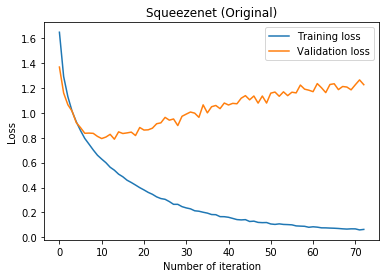

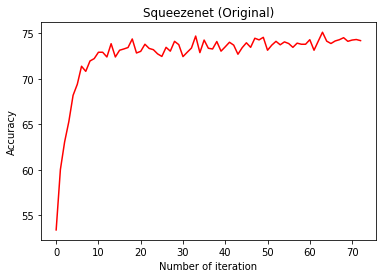

Mean time per epoch 28.08398314573972 seconds
Best accuracy: 75.12  Best training loss: 0.05943454007990658  Best validation loss: 0.7881953290104867


In [0]:
  # visualization loss 
plt.plot(iteration_list,loss_list, label='Training loss')
plt.plot(iteration_list,loss_list_test, label='Validation loss')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Squeezenet (Original)")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("Squeezenet (Original)")
plt.show()

print(f"Mean time per epoch {np.mean(execution_time)} seconds") # returns time in sec 
print(f"Best accuracy: {best_acc}  Best training loss: {min(loss_list)}  Best validation loss: {min(loss_list_test)}")


In [0]:
print(str(iteration_list))
print(str(loss_list))
print(str(loss_list_test))
print(str(accuracy_list))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]
[1.6473578805923461, 1.2915961208343505, 1.1294073311686517, 1.012139591217041, 0.9274672510027886, 0.8571678162813187, 0.7942030563950538, 0.7484979167580604, 0.7018296536207199, 0.6593402114212513, 0.6284279014766216, 0.5993730073273182, 0.5629559449702501, 0.5391781126409769, 0.5073888074159623, 0.486400278031826, 0.4587193107157946, 0.4403483587652445, 0.42000688348710535, 0.3989686287492514, 0.38070115342736244, 0.3609559191688895, 0.3455553373545408, 0.3248455015718937, 0.3113302046880126, 0.30523529996350407, 0.2871591752246022, 0.2649945173449814, 0.26498789989203214, 0.24644527194648982, 0.23623166743293406, 0.22884558813646436, 0.21318567657098175, 0.20962583773210644, 0.2013636082932353, 0.1944571

## alexnet

In [0]:
import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo

__all__ = ['AlexNet', 'alexnet']


model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

NUM_CLASSES = 10

class AlexNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        return x


def alexnet(pretrained=False, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = AlexNet(**kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['alexnet']))
    return model

In [0]:

#change the line below for different models
model = alexnet(num_classes=10)

# print(model)

model = model.to(device=device, dtype=torch.float)

# Cross Entropy Loss 
error = CrossEntropyLoss().to(device=device, dtype=torch.float)

#Optimizer
learning_rate = 0.1
optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=learning_rate)


#Optimizer adam
# learning_rate = 0.1
# optimizer = Adam(model.parameters(), lr=learning_rate)
#optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, dampening=0, weight_decay=0.0002, nesterov=False)
# optimizer = SGD(model.parameters(), lr=learning_rate)
#adaptive learning rate
# how many epoc before decreasing learning rate
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [0]:
%%time
#training/testing
loss_list = []
loss_list_test = []
iteration_list = []
accuracy_list = []
# execution time checking
execution_time = []

PATH = '/content/alexnet_acc.pth'
best_model_wts = copy.deepcopy(model.state_dict())
PATH2 = '/content/alexnet_loss.pth'
best_model_loss = copy.deepcopy(model.state_dict())

#PATH = '/content/modified_mnist_effb2_pre_original_latest.pth'
#latest_model_wts = copy.deepcopy(model.state_dict())
best_loss = float("inf")
best_acc = 0.0
#set number of epochs 
num_epochs = 20
for epoch in range(num_epochs):
    #print("\nTrain Epoch {}: lr = {}".format(epoch, exp_lr_scheduler.get_lr()[0]))
    print("\nTrain Epoch {}: lr = {}".format(epoch,learning_rate))

    start = timeit.default_timer()
    loss_list.append(train(epoch, train_loader, model, error, optimizer, batch_size))
    loss_test, accuracy = test(test_loader, model, error, batch_size)
    stop = timeit.default_timer()
    etime = stop - start
    execution_time.append(etime)

    loss_list_test.append(loss_test)
    accuracy_list.append(accuracy)
    iteration_list.append(epoch)
    #exp_lr_scheduler.step()

    #saving model with best acc 
    if accuracy > best_acc:
      print(f"Better accuracy at Epoch {epoch}: accuracy = {accuracy}%")
      best_acc = accuracy
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(best_model_wts, PATH)
    #saving model with best loss
    if loss_test < best_loss:
      print(f"Better loss at Epoch {epoch}: loss = {loss_test}%")
      best_loss = loss_test
      best_model_loss = copy.deepcopy(model.state_dict())
      torch.save(best_model_loss, PATH2)
#load model
# model = Net()
# model.load_state_dict(torch.load(PATH))


Train Epoch 0: lr = 0.1
Train Epoch: 0 [5000/50000 (10%)]	Train Loss: 2.210915
Train Epoch: 0 [10000/50000 (20%)]	Train Loss: 1.962640
Train Epoch: 0 [15000/50000 (30%)]	Train Loss: 1.836767
Train Epoch: 0 [20000/50000 (40%)]	Train Loss: 1.748397
Train Epoch: 0 [25000/50000 (50%)]	Train Loss: 1.695877
Train Epoch: 0 [30000/50000 (60%)]	Train Loss: 1.640653
Train Epoch: 0 [35000/50000 (70%)]	Train Loss: 1.580237
Train Epoch: 0 [40000/50000 (80%)]	Train Loss: 1.542793
Train Epoch: 0 [45000/50000 (90%)]	Train Loss: 1.502671

Test set: Test loss: 1.4176, Accuracy: 2343/5000 (47%)

Better accuracy at Epoch 0: accuracy = 46.86%
Better loss at Epoch 0: loss = 1.4175948703289025%

Train Epoch 1: lr = 0.1
Train Epoch: 1 [5000/50000 (10%)]	Train Loss: 1.440749
Train Epoch: 1 [10000/50000 (20%)]	Train Loss: 1.374844
Train Epoch: 1 [15000/50000 (30%)]	Train Loss: 1.375904
Train Epoch: 1 [20000/50000 (40%)]	Train Loss: 1.352652
Train Epoch: 1 [25000/50000 (50%)]	Train Loss: 1.330812
Train Epoch: 1

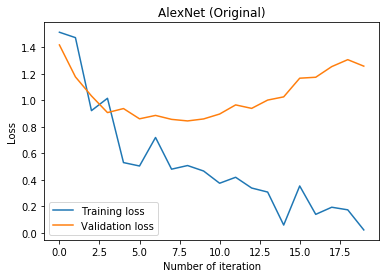

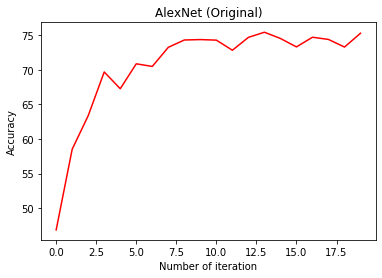

Mean time per epoch 17.45083315845013 seconds
Best accuracy: 75.42  Best training loss: 0.02247416414320469  Best validation loss: 0.8444360390305519


In [0]:
# visualization loss 
plt.plot(iteration_list,loss_list, label='Training loss')
plt.plot(iteration_list,loss_list_test, label='Validation loss')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("AlexNet (Original)")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("AlexNet (Original)")
plt.show()

print(f"Mean time per epoch {np.mean(execution_time)} seconds") # returns time in sec 
print(f"Best accuracy: {best_acc}  Best training loss: {min(loss_list)}  Best validation loss: {min(loss_list_test)}")


In [0]:
print(str(iteration_list))
print(str(loss_list))
print(str(loss_list_test))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[1.6308766603469849, 1.3429898023605347, 0.9622616767883301, 1.1100956201553345, 0.655852735042572, 0.524598240852356, 0.7864339351654053, 0.621737003326416, 0.502821683883667, 0.7517127990722656, 0.18797433376312256, 0.19942814111709595, 0.21666258573532104, 0.15186657011508942, 0.31530871987342834, 0.07428207993507385, 0.37790507078170776, 0.06306121498346329, 0.0740111768245697, 0.14583754539489746]
[1.409133423566818, 1.2283282226324086, 1.0814817500114442, 0.8936923462152482, 0.8564886212348937, 0.8699691197276113, 0.8164491868019103, 0.7932574903964993, 0.752289607822895, 0.8448375365138052, 0.8733229354023934, 0.8786852282285693, 0.9630569016933443, 1.024801244735718, 0.993808183670044, 1.0776556742191314, 1.18092718243599, 1.131519162505865, 1.1523174196481705, 1.2154082900285719]


## alexnet (batch normed)

In [0]:
import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo

__all__ = ['AlexNet', 'alexnet']


model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

NUM_CLASSES = 10

class AlexNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        return x


def alexnet(pretrained=False, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = AlexNet(**kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['alexnet']))
    return model

In [0]:

#change the line below for different models
model = alexnet(num_classes=10)

# print(model)

model = model.to(device=device, dtype=torch.float)

# Cross Entropy Loss 
error = CrossEntropyLoss().to(device=device, dtype=torch.float)

#Optimizer
learning_rate = 0.1
optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=learning_rate)


#Optimizer adam
# learning_rate = 0.1
# optimizer = Adam(model.parameters(), lr=learning_rate)
#optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, dampening=0, weight_decay=0.0002, nesterov=False)
# optimizer = SGD(model.parameters(), lr=learning_rate)
#adaptive learning rate
# how many epoc before decreasing learning rate
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [0]:
%%time
#training/testing
loss_list = []
loss_list_test = []
iteration_list = []
accuracy_list = []
# execution time checking
execution_time = []

PATH = '/content/alexnet_acc.pth'
best_model_wts = copy.deepcopy(model.state_dict())
PATH2 = '/content/alexnet_loss.pth'
best_model_loss = copy.deepcopy(model.state_dict())

#PATH = '/content/modified_mnist_effb2_pre_original_latest.pth'
#latest_model_wts = copy.deepcopy(model.state_dict())
best_loss = float("inf")
best_acc = 0.0
#set number of epochs 
num_epochs = 20
for epoch in range(num_epochs):
    #print("\nTrain Epoch {}: lr = {}".format(epoch, exp_lr_scheduler.get_lr()[0]))
    print("\nTrain Epoch {}: lr = {}".format(epoch,learning_rate))

    start = timeit.default_timer()
    loss_list.append(train(epoch, train_loader, model, error, optimizer, batch_size))
    loss_test, accuracy = test(test_loader, model, error, batch_size)
    stop = timeit.default_timer()
    etime = stop - start
    execution_time.append(etime)

    loss_list_test.append(loss_test)
    accuracy_list.append(accuracy)
    iteration_list.append(epoch)
    #exp_lr_scheduler.step()

    #saving model with best acc 
    if accuracy > best_acc:
      print(f"Better accuracy at Epoch {epoch}: accuracy = {accuracy}%")
      best_acc = accuracy
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(best_model_wts, PATH)
    #saving model with best loss
    if loss_test < best_loss:
      print(f"Better loss at Epoch {epoch}: loss = {loss_test}%")
      best_loss = loss_test
      best_model_loss = copy.deepcopy(model.state_dict())
      torch.save(best_model_loss, PATH2)
#load model
# model = Net()
# model.load_state_dict(torch.load(PATH))


Train Epoch 0: lr = 0.1
Train Epoch: 0 [5000/50000 (10%)]	Train Loss: 2.230557
Train Epoch: 0 [10000/50000 (20%)]	Train Loss: 1.835540
Train Epoch: 0 [15000/50000 (30%)]	Train Loss: 1.776237
Train Epoch: 0 [20000/50000 (40%)]	Train Loss: 1.689643
Train Epoch: 0 [25000/50000 (50%)]	Train Loss: 1.510512
Train Epoch: 0 [30000/50000 (60%)]	Train Loss: 1.647828
Train Epoch: 0 [35000/50000 (70%)]	Train Loss: 1.522134
Train Epoch: 0 [40000/50000 (80%)]	Train Loss: 1.442038
Train Epoch: 0 [45000/50000 (90%)]	Train Loss: 1.510945

Test set: Test loss: 1.3165, Accuracy: 2795/5000 (56%)

Better accuracy at Epoch 0: accuracy = 55.9%
Better loss at Epoch 0: loss = 1.316491122245789%

Train Epoch 1: lr = 0.1
Train Epoch: 1 [5000/50000 (10%)]	Train Loss: 1.391351
Train Epoch: 1 [10000/50000 (20%)]	Train Loss: 1.408898
Train Epoch: 1 [15000/50000 (30%)]	Train Loss: 1.286650
Train Epoch: 1 [20000/50000 (40%)]	Train Loss: 1.319900
Train Epoch: 1 [25000/50000 (50%)]	Train Loss: 1.334819
Train Epoch: 1 [

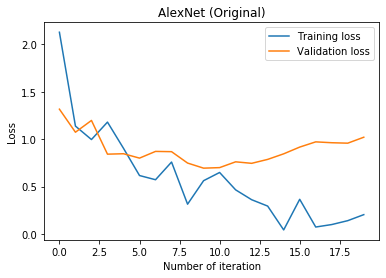

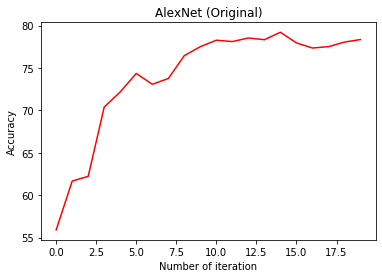

Mean time per epoch 20.120753936350138 seconds
Best accuracy: 79.22  Best training loss: 0.04313662648200989  Best validation loss: 0.6944435071945192


In [0]:
# visualization loss 
plt.plot(iteration_list,loss_list, label='Training loss')
plt.plot(iteration_list,loss_list_test, label='Validation loss')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("AlexNet (Original)")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("AlexNet (Original)")
plt.show()

print(f"Mean time per epoch {np.mean(execution_time)} seconds") # returns time in sec 
print(f"Best accuracy: {best_acc}  Best training loss: {min(loss_list)}  Best validation loss: {min(loss_list_test)}")


In [0]:
print(str(iteration_list))
print(str(loss_list))
print(str(loss_list_test))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[2.1278011798858643, 1.1381068229675293, 0.9963151812553406, 1.1801337003707886, 0.9036651849746704, 0.6166149973869324, 0.572441577911377, 0.7587618827819824, 0.3146998882293701, 0.562298595905304, 0.6489260792732239, 0.4657740890979767, 0.3616662919521332, 0.29444873332977295, 0.04313662648200989, 0.3660165071487427, 0.07367490977048874, 0.09971118718385696, 0.1407468020915985, 0.20423555374145508]
[1.316491122245789, 1.073440764546394, 1.1976761949062353, 0.8420078158378599, 0.8465766867995264, 0.8003313493728638, 0.8711158382892606, 0.8683207330107691, 0.7482532548904418, 0.6944435071945192, 0.7000897952914238, 0.7612647596001625, 0.7454007494449618, 0.7868634825944898, 0.8455694338679317, 0.9166489326953885, 0.9717262905836105, 0.9625885799527166, 0.9579475793242452, 1.0206879660487171]


## squeeze net

In [0]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo

__all__ = ['SqueezeNet', 'squeezenet1_0', 'squeezenet1_1']

model_urls = {
    'squeezenet1_0': 'https://download.pytorch.org/models/squeezenet1_0-a815701f.pth',
    'squeezenet1_1': 'https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth',
}


class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat([
            self.expand1x1_activation(self.expand1x1(x)),
            self.expand3x3_activation(self.expand3x3(x))
        ], 1)


class SqueezeNet(nn.Module):

    def __init__(self, version='1_0', num_classes=1000):
        super(SqueezeNet, self).__init__()
        self.num_classes = num_classes
        if version == '1_0':
            self.features = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=7, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 16, 64, 64),
                Fire(128, 16, 64, 64),
                Fire(128, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 32, 128, 128),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(512, 64, 256, 256),
            )
        elif version == '1_1':
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(64, 16, 64, 64),
                Fire(128, 16, 64, 64),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(128, 32, 128, 128),
                Fire(256, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                Fire(512, 64, 256, 256),
            )
        else:
            # FIXME: Is this needed? SqueezeNet should only be called from the
            # FIXME: squeezenet1_x() functions
            # FIXME: This checking is not done for the other models
            raise ValueError("Unsupported SqueezeNet version {version}:"
                             "1_0 or 1_1 expected".format(version=version))

        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return torch.flatten(x, 1)


def _squeezenet(version, pretrained, progress, **kwargs):
    model = SqueezeNet(version, **kwargs)
    if pretrained:
        arch = 'squeezenet' + version
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def squeezenet1_0(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet model architecture from the `"SqueezeNet: AlexNet-level
    accuracy with 50x fewer parameters and <0.5MB model size"
    <https://arxiv.org/abs/1602.07360>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_0', pretrained, progress, **kwargs)


def squeezenet1_1(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet 1.1 model from the `official SqueezeNet repo
    <https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1>`_.
    SqueezeNet 1.1 has 2.4x less computation and slightly fewer parameters
    than SqueezeNet 1.0, without sacrificing accuracy.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_1', pretrained, progress, **kwargs)

In [0]:

#change the line below for different models

# import torchvision.models as models
# model = models.squeezenet1_0(pretrained=True)

model = squeezenet1_0(num_classes=10)

# print(model)

model = model.to(device=device, dtype=torch.float)

# Cross Entropy Loss 
error = CrossEntropyLoss().to(device=device, dtype=torch.float)

#Optimizer
learning_rate = 0.1
optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=learning_rate)

#Optimizer adam
# learning_rate = 0.04
# optimizer = Adam(model.parameters(), lr=learning_rate)
# optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, dampening=0, weight_decay=0.0002, nesterov=False)
#optimizer = SGD(model.parameters(), lr=learning_rate)

#adaptive learning rate
# how many epoc before decreasing learning rate
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [0]:
#load trained dictionary
PATH = '/content/squeezenet_loss.pth'
model.load_state_dict(torch.load(PATH))

In [0]:
%%time
#training/testing
loss_list = []
loss_list_test = []
iteration_list = []
accuracy_list = []
# execution time checking
execution_time = []

PATH = '/content/squeezenet_acc.pth'
best_model_wts = copy.deepcopy(model.state_dict())
PATH2 = '/content/squeezenet_loss.pth'
best_model_loss = copy.deepcopy(model.state_dict())

#PATH = '/content/modified_mnist_effb2_pre_original_latest.pth'
#latest_model_wts = copy.deepcopy(model.state_dict())
best_loss = float("inf")
best_acc = 0.0
#set number of epochs 
num_epochs = 100
for epoch in range(num_epochs):
    #print("\nTrain Epoch {}: lr = {}".format(epoch, exp_lr_scheduler.get_lr()[0]))
    print("\nTrain Epoch {}: lr = {}".format(epoch,learning_rate))

    start = timeit.default_timer()
    loss_list.append(train(epoch, train_loader, model, error, optimizer, batch_size))
    loss_test, accuracy = test(test_loader, model, error, batch_size)
    stop = timeit.default_timer()
    etime = stop - start
    execution_time.append(etime)

    loss_list_test.append(loss_test)
    accuracy_list.append(accuracy)
    iteration_list.append(epoch)
    #exp_lr_scheduler.step()

    #saving model with best acc 
    if accuracy > best_acc:
      print(f"Better accuracy at Epoch {epoch}: accuracy = {accuracy}%")
      best_acc = accuracy
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(best_model_wts, PATH)
    #saving model with best loss
    if loss_test < best_loss:
      print(f"Better loss at Epoch {epoch}: loss = {loss_test}%")
      best_loss = loss_test
      best_model_loss = copy.deepcopy(model.state_dict())
      torch.save(best_model_loss, PATH2)
#load model
# model = Net()
# model.load_state_dict(torch.load(PATH))


Train Epoch 0: lr = 0.1
Train Epoch: 0 [5000/50000 (10%)]	Train Loss: 2.325723
Train Epoch: 0 [10000/50000 (20%)]	Train Loss: 2.302612
Train Epoch: 0 [15000/50000 (30%)]	Train Loss: 2.302475
Train Epoch: 0 [20000/50000 (40%)]	Train Loss: 2.300115
Train Epoch: 0 [25000/50000 (50%)]	Train Loss: 2.286658
Train Epoch: 0 [30000/50000 (60%)]	Train Loss: 2.299698
Train Epoch: 0 [35000/50000 (70%)]	Train Loss: 2.302803
Train Epoch: 0 [40000/50000 (80%)]	Train Loss: 2.302632
Train Epoch: 0 [45000/50000 (90%)]	Train Loss: 2.302368

Test set: Test loss: 2.3017, Accuracy: 775/5000 (16%)

Better accuracy at Epoch 0: accuracy = 15.5%
Better loss at Epoch 0: loss = 2.3017338275909416%

Train Epoch 1: lr = 0.1
Train Epoch: 1 [5000/50000 (10%)]	Train Loss: 2.324977
Train Epoch: 1 [10000/50000 (20%)]	Train Loss: 2.300792
Train Epoch: 1 [15000/50000 (30%)]	Train Loss: 2.294339
Train Epoch: 1 [20000/50000 (40%)]	Train Loss: 2.283263
Train Epoch: 1 [25000/50000 (50%)]	Train Loss: 2.296012
Train Epoch: 1 [

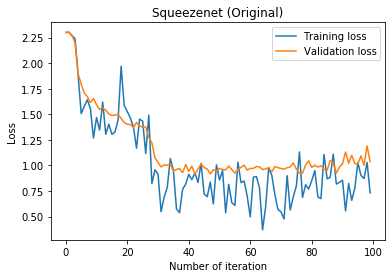

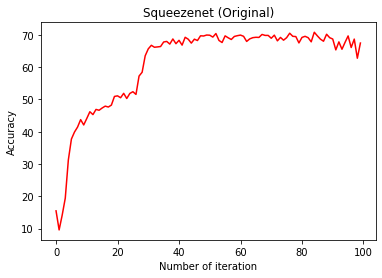

Mean time per epoch 25.25911299897005 seconds
Best accuracy: 70.76  Best training loss: 0.3689083755016327  Best validation loss: 0.915341284275055


In [0]:
  # visualization loss 
plt.plot(iteration_list,loss_list, label='Training loss')
plt.plot(iteration_list,loss_list_test, label='Validation loss')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Squeezenet (Original)")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("Squeezenet (Original)")
plt.show()

print(f"Mean time per epoch {np.mean(execution_time)} seconds") # returns time in sec 
print(f"Best accuracy: {best_acc}  Best training loss: {min(loss_list)}  Best validation loss: {min(loss_list_test)}")


In [0]:
print(str(iteration_list))
print(str(loss_list))
print(str(loss_list_test))
print(str(accuracy_list))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[2.299943208694458, 2.302584409713745, 2.2689270973205566, 2.2405292987823486, 1.8913905620574951, 1.5071830749511719, 1.5770992040634155, 1.6421047449111938, 1.5562281608581543, 1.2674864530563354, 1.4688975811004639, 1.3458105325698853, 1.619601845741272, 1.3046716451644897, 1.403365135192871, 1.3041883707046509, 1.3262447118759155, 1.4430848360061646, 1.969878077507019, 1.5856781005859375, 1.5277986526489258, 1.4632666110992432, 1.3772468566894531, 1.1684536933898926, 1.453433632850647, 1.4331430196762085, 1.1156573295593262, 1.4916654825210571, 0.8227909207344055, 0.9565484523773193, 0.916340172290

## squeeze net (batch normed) (3x3 ratio 0.125)

In [0]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo

__all__ = ['SqueezeNet', 'squeezenet1_0', 'squeezenet1_1']

model_urls = {
    'squeezenet1_0': 'https://download.pytorch.org/models/squeezenet1_0-a815701f.pth',
    'squeezenet1_1': 'https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth',
}


class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.bns1 = nn.BatchNorm2d(squeeze_planes)

        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.bne1 = nn.BatchNorm2d(expand1x1_planes)

        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        self.bne3 = nn.BatchNorm2d(expand3x3_planes)

        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.bns1(self.squeeze(x)))


        return torch.cat([
            self.expand1x1_activation(self.bne1(self.expand1x1(x))),
            self.expand3x3_activation(self.bne3(self.expand3x3(x)))
        ], 1)


class SqueezeNet(nn.Module):

    def __init__(self, version='1_0', num_classes=1000):
        super(SqueezeNet, self).__init__()
        self.num_classes = num_classes
        if version == '1_0':
            self.features = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=7, stride=2),
                nn.BatchNorm2d(96),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 16, 112,16),
                Fire(128, 16, 112,16),
                Fire(128, 32, 224,32),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 32, 224,32),
                Fire(256, 48, 336,48),
                Fire(384, 48, 336,48),
                Fire(384, 64, 448,64),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(512, 64, 448,64),
            )
        elif version == '1_1':
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(64, 16, 64, 64),
                Fire(128, 16, 64, 64),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(128, 32, 128, 128),
                Fire(256, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                Fire(512, 64, 256, 256),
            )
        else:
            # FIXME: Is this needed? SqueezeNet should only be called from the
            # FIXME: squeezenet1_x() functions
            # FIXME: This checking is not done for the other models
            raise ValueError("Unsupported SqueezeNet version {version}:"
                             "1_0 or 1_1 expected".format(version=version))

        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.BatchNorm2d(self.num_classes),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return torch.flatten(x, 1)


def _squeezenet(version, pretrained, progress, **kwargs):
    model = SqueezeNet(version, **kwargs)
    if pretrained:
        arch = 'squeezenet' + version
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def squeezenet1_0(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet model architecture from the `"SqueezeNet: AlexNet-level
    accuracy with 50x fewer parameters and <0.5MB model size"
    <https://arxiv.org/abs/1602.07360>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_0', pretrained, progress, **kwargs)


def squeezenet1_1(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet 1.1 model from the `official SqueezeNet repo
    <https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1>`_.
    SqueezeNet 1.1 has 2.4x less computation and slightly fewer parameters
    than SqueezeNet 1.0, without sacrificing accuracy.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_1', pretrained, progress, **kwargs)


In [0]:

#change the line below for different models

# import torchvision.models as models
# model = models.squeezenet1_0(pretrained=True)

model = squeezenet1_0(num_classes=10)

# print(model)

model = model.to(device=device, dtype=torch.float)

# Cross Entropy Loss 
error = CrossEntropyLoss().to(device=device, dtype=torch.float)

#Optimizer
learning_rate = 0.1
optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=learning_rate)

#Optimizer adam
# learning_rate = 0.04
# optimizer = Adam(model.parameters(), lr=learning_rate)
# optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, dampening=0, weight_decay=0.0002, nesterov=False)
#optimizer = SGD(model.parameters(), lr=learning_rate)

#adaptive learning rate
# how many epoc before decreasing learning rate
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [0]:
#load trained dictionary
PATH = '/content/squeezenet_loss.pth'
model.load_state_dict(torch.load(PATH))

In [0]:
%%time
#training/testing
loss_list = []
loss_list_test = []
iteration_list = []
accuracy_list = []
# execution time checking
execution_time = []

PATH = '/content/squeezenet_acc.pth'
best_model_wts = copy.deepcopy(model.state_dict())
PATH2 = '/content/squeezenet_loss.pth'
best_model_loss = copy.deepcopy(model.state_dict())

#PATH = '/content/modified_mnist_effb2_pre_original_latest.pth'
#latest_model_wts = copy.deepcopy(model.state_dict())
best_loss = float("inf")
best_acc = 0.0
#set number of epochs 
num_epochs = 100
for epoch in range(num_epochs):
    #print("\nTrain Epoch {}: lr = {}".format(epoch, exp_lr_scheduler.get_lr()[0]))
    print("\nTrain Epoch {}: lr = {}".format(epoch,learning_rate))

    start = timeit.default_timer()
    loss_list.append(train(epoch, train_loader, model, error, optimizer, batch_size))
    loss_test, accuracy = test(test_loader, model, error, batch_size)
    stop = timeit.default_timer()
    etime = stop - start
    execution_time.append(etime)

    loss_list_test.append(loss_test)
    accuracy_list.append(accuracy)
    iteration_list.append(epoch)
    #exp_lr_scheduler.step()

    #saving model with best acc 
    if accuracy > best_acc:
      print(f"Better accuracy at Epoch {epoch}: accuracy = {accuracy}%")
      best_acc = accuracy
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(best_model_wts, PATH)
    #saving model with best loss
    if loss_test < best_loss:
      print(f"Better loss at Epoch {epoch}: loss = {loss_test}%")
      best_loss = loss_test
      best_model_loss = copy.deepcopy(model.state_dict())
      torch.save(best_model_loss, PATH2)
#load model
# model = Net()
# model.load_state_dict(torch.load(PATH))


Train Epoch 0: lr = 0.1
Train Epoch: 0 [5000/50000 (10%)]	Train Loss: 2.217637
Train Epoch: 0 [10000/50000 (20%)]	Train Loss: 2.025467
Train Epoch: 0 [15000/50000 (30%)]	Train Loss: 1.924834
Train Epoch: 0 [20000/50000 (40%)]	Train Loss: 1.848480
Train Epoch: 0 [25000/50000 (50%)]	Train Loss: 1.789724
Train Epoch: 0 [30000/50000 (60%)]	Train Loss: 1.760014
Train Epoch: 0 [35000/50000 (70%)]	Train Loss: 1.710910
Train Epoch: 0 [40000/50000 (80%)]	Train Loss: 1.655862
Train Epoch: 0 [45000/50000 (90%)]	Train Loss: 1.632373
Total train loss: 1.8168

Test set: Test loss: 1.5600, Accuracy: 2215/5000 (44%)

Better accuracy at Epoch 0: accuracy = 44.3%
Better loss at Epoch 0: loss = 1.5600179243087768%

Train Epoch 1: lr = 0.1
Train Epoch: 1 [5000/50000 (10%)]	Train Loss: 1.595686
Train Epoch: 1 [10000/50000 (20%)]	Train Loss: 1.533136
Train Epoch: 1 [15000/50000 (30%)]	Train Loss: 1.517072
Train Epoch: 1 [20000/50000 (40%)]	Train Loss: 1.513740
Train Epoch: 1 [25000/50000 (50%)]	Train Loss:

KeyboardInterrupt: ignored

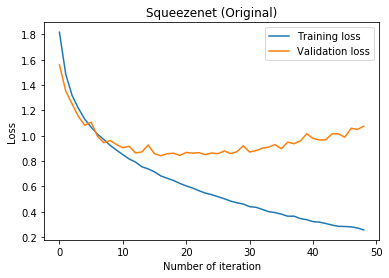

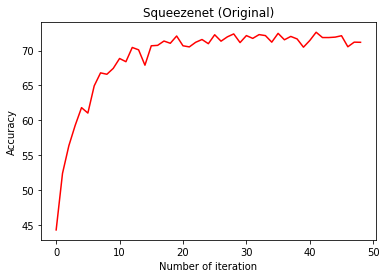

Mean time per epoch 34.49524099771432 seconds
Best accuracy: 72.62  Best training loss: 0.25634893817827104  Best validation loss: 0.8419499099254606


In [0]:
  # visualization loss 
plt.plot(iteration_list,loss_list, label='Training loss')
plt.plot(iteration_list,loss_list_test, label='Validation loss')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Squeezenet (Original)")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("Squeezenet (Original)")
plt.show()

print(f"Mean time per epoch {np.mean(execution_time)} seconds") # returns time in sec 
print(f"Best accuracy: {best_acc}  Best training loss: {min(loss_list)}  Best validation loss: {min(loss_list_test)}")


In [0]:
print(str(iteration_list))
print(str(loss_list))
print(str(loss_list_test))
print(str(accuracy_list))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
[1.8168393324613572, 1.4847788677215576, 1.3182759776115418, 1.215897289454937, 1.130046290040016, 1.0679998506903647, 1.0120616449713706, 0.9703730442523957, 0.9238243085443973, 0.8861975490450859, 0.8506102685332299, 0.8163609268069267, 0.7921581084132194, 0.7548786562681198, 0.7379953045845031, 0.7143634339272976, 0.6824760676622391, 0.6640138252973556, 0.6464400825202465, 0.6233637531101703, 0.6035101274549961, 0.5871770976036788, 0.565795158624649, 0.547414325043559, 0.5346717781573535, 0.5186531174182892, 0.5025907101780176, 0.48371973502635957, 0.47048676627874375, 0.46047647750377657, 0.439719740152359, 0.4351905076652765, 0.41816240069270133, 0.4004596504494548, 0.3929821141958237, 0.3807932251095772, 0.36473384764045474, 0.36500578248500826, 0.3459587673544884, 0.33704183156043294, 0.32168000

## squeeze net (batch normed) (3x3 ratio 0.25)

In [0]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo

__all__ = ['SqueezeNet', 'squeezenet1_0', 'squeezenet1_1']

model_urls = {
    'squeezenet1_0': 'https://download.pytorch.org/models/squeezenet1_0-a815701f.pth',
    'squeezenet1_1': 'https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth',
}


class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.bns1 = nn.BatchNorm2d(squeeze_planes)

        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.bne1 = nn.BatchNorm2d(expand1x1_planes)

        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        self.bne3 = nn.BatchNorm2d(expand3x3_planes)

        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.bns1(self.squeeze(x)))


        return torch.cat([
            self.expand1x1_activation(self.bne1(self.expand1x1(x))),
            self.expand3x3_activation(self.bne3(self.expand3x3(x)))
        ], 1)


class SqueezeNet(nn.Module):

    def __init__(self, version='1_0', num_classes=1000):
        super(SqueezeNet, self).__init__()
        self.num_classes = num_classes
        if version == '1_0':
            self.features = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=7, stride=2),
                nn.BatchNorm2d(96),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 16, 96,32),
                Fire(128, 16, 96,32),
                Fire(128, 32, 192,64),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 32, 192,64),
                Fire(256, 48, 288,96),
                Fire(384, 48, 288,96),
                Fire(384, 64, 384,128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(512, 64, 384,128),
            )
        elif version == '1_1':
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(64, 16, 64, 64),
                Fire(128, 16, 64, 64),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(128, 32, 128, 128),
                Fire(256, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                Fire(512, 64, 256, 256),
            )
        else:
            # FIXME: Is this needed? SqueezeNet should only be called from the
            # FIXME: squeezenet1_x() functions
            # FIXME: This checking is not done for the other models
            raise ValueError("Unsupported SqueezeNet version {version}:"
                             "1_0 or 1_1 expected".format(version=version))

        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.BatchNorm2d(self.num_classes),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return torch.flatten(x, 1)


def _squeezenet(version, pretrained, progress, **kwargs):
    model = SqueezeNet(version, **kwargs)
    if pretrained:
        arch = 'squeezenet' + version
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def squeezenet1_0(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet model architecture from the `"SqueezeNet: AlexNet-level
    accuracy with 50x fewer parameters and <0.5MB model size"
    <https://arxiv.org/abs/1602.07360>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_0', pretrained, progress, **kwargs)


def squeezenet1_1(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet 1.1 model from the `official SqueezeNet repo
    <https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1>`_.
    SqueezeNet 1.1 has 2.4x less computation and slightly fewer parameters
    than SqueezeNet 1.0, without sacrificing accuracy.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_1', pretrained, progress, **kwargs)


In [0]:

#change the line below for different models

# import torchvision.models as models
# model = models.squeezenet1_0(pretrained=True)

model = squeezenet1_0(num_classes=10)

# print(model)

model = model.to(device=device, dtype=torch.float)

# Cross Entropy Loss 
error = CrossEntropyLoss().to(device=device, dtype=torch.float)

#Optimizer
learning_rate = 0.1
optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=learning_rate)

#Optimizer adam
# learning_rate = 0.04
# optimizer = Adam(model.parameters(), lr=learning_rate)
# optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, dampening=0, weight_decay=0.0002, nesterov=False)
#optimizer = SGD(model.parameters(), lr=learning_rate)

#adaptive learning rate
# how many epoc before decreasing learning rate
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [0]:
#load trained dictionary
PATH = '/content/squeezenet_loss.pth'
model.load_state_dict(torch.load(PATH))

In [0]:
%%time
#training/testing
loss_list = []
loss_list_test = []
iteration_list = []
accuracy_list = []
# execution time checking
execution_time = []

PATH = '/content/squeezenet_acc.pth'
best_model_wts = copy.deepcopy(model.state_dict())
PATH2 = '/content/squeezenet_loss.pth'
best_model_loss = copy.deepcopy(model.state_dict())

#PATH = '/content/modified_mnist_effb2_pre_original_latest.pth'
#latest_model_wts = copy.deepcopy(model.state_dict())
best_loss = float("inf")
best_acc = 0.0
#set number of epochs 
num_epochs = 100
for epoch in range(num_epochs):
    #print("\nTrain Epoch {}: lr = {}".format(epoch, exp_lr_scheduler.get_lr()[0]))
    print("\nTrain Epoch {}: lr = {}".format(epoch,learning_rate))

    start = timeit.default_timer()
    loss_list.append(train(epoch, train_loader, model, error, optimizer, batch_size))
    loss_test, accuracy = test(test_loader, model, error, batch_size)
    stop = timeit.default_timer()
    etime = stop - start
    execution_time.append(etime)

    loss_list_test.append(loss_test)
    accuracy_list.append(accuracy)
    iteration_list.append(epoch)
    #exp_lr_scheduler.step()

    #saving model with best acc 
    if accuracy > best_acc:
      print(f"Better accuracy at Epoch {epoch}: accuracy = {accuracy}%")
      best_acc = accuracy
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(best_model_wts, PATH)
    #saving model with best loss
    if loss_test < best_loss:
      print(f"Better loss at Epoch {epoch}: loss = {loss_test}%")
      best_loss = loss_test
      best_model_loss = copy.deepcopy(model.state_dict())
      torch.save(best_model_loss, PATH2)
#load model
# model = Net()
# model.load_state_dict(torch.load(PATH))


Train Epoch 0: lr = 0.1
Train Epoch: 0 [5000/50000 (10%)]	Train Loss: 2.246792
Train Epoch: 0 [10000/50000 (20%)]	Train Loss: 2.032425
Train Epoch: 0 [15000/50000 (30%)]	Train Loss: 1.929960
Train Epoch: 0 [20000/50000 (40%)]	Train Loss: 1.840240
Train Epoch: 0 [25000/50000 (50%)]	Train Loss: 1.805132
Train Epoch: 0 [30000/50000 (60%)]	Train Loss: 1.736134
Train Epoch: 0 [35000/50000 (70%)]	Train Loss: 1.699053
Train Epoch: 0 [40000/50000 (80%)]	Train Loss: 1.671553
Train Epoch: 0 [45000/50000 (90%)]	Train Loss: 1.611074
Total train loss: 1.8181

Test set: Test loss: 1.5329, Accuracy: 2300/5000 (46%)

Better accuracy at Epoch 0: accuracy = 46.0%
Better loss at Epoch 0: loss = 1.532898788452149%

Train Epoch 1: lr = 0.1
Train Epoch: 1 [5000/50000 (10%)]	Train Loss: 1.548183
Train Epoch: 1 [10000/50000 (20%)]	Train Loss: 1.534670
Train Epoch: 1 [15000/50000 (30%)]	Train Loss: 1.513521
Train Epoch: 1 [20000/50000 (40%)]	Train Loss: 1.476334
Train Epoch: 1 [25000/50000 (50%)]	Train Loss: 

KeyboardInterrupt: ignored

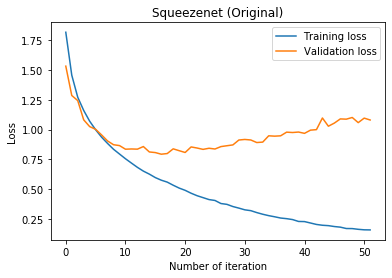

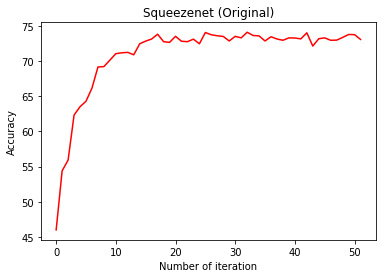

Mean time per epoch 34.292118758153904 seconds
Best accuracy: 74.08  Best training loss: 0.15568388721346854  Best validation loss: 0.7924620547890665


In [0]:
  # visualization loss 
plt.plot(iteration_list,loss_list, label='Training loss')
plt.plot(iteration_list,loss_list_test, label='Validation loss')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Squeezenet (Original)")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("Squeezenet (Original)")
plt.show()

print(f"Mean time per epoch {np.mean(execution_time)} seconds") # returns time in sec 
print(f"Best accuracy: {best_acc}  Best training loss: {min(loss_list)}  Best validation loss: {min(loss_list_test)}")


In [0]:
print(str(iteration_list))
print(str(loss_list))
print(str(loss_list_test))
print(str(accuracy_list))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]
[1.8180818259716034, 1.4572993639707565, 1.2719646226167678, 1.1604638813734054, 1.0699988037347794, 0.9980746896266938, 0.9355610894560814, 0.882878409564495, 0.8338646187782287, 0.793876740694046, 0.7541562731266022, 0.7177694869935513, 0.6819172051548957, 0.6501521447002888, 0.6248666300475597, 0.5958057281374931, 0.573871077939868, 0.5576381465196609, 0.5314415907114745, 0.5074381946772337, 0.48857979716360567, 0.46418102568387987, 0.4433420429080725, 0.4271464377641678, 0.4108445409461856, 0.4032571386024356, 0.3775452640801668, 0.3706348918005824, 0.3522555408105254, 0.33906378839164975, 0.3246300146356225, 0.3176314008533955, 0.30148927933722736, 0.2874620287418366, 0.27571548099070786, 0.26615336583927274, 0.2555813882499933, 0.25032045352458954, 0.24266249246522784, 0.2268893757350

## squeeze net (batch normed) (3x3 ratio 0.75)

In [0]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo

__all__ = ['SqueezeNet', 'squeezenet1_0', 'squeezenet1_1']

model_urls = {
    'squeezenet1_0': 'https://download.pytorch.org/models/squeezenet1_0-a815701f.pth',
    'squeezenet1_1': 'https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth',
}


class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.bns1 = nn.BatchNorm2d(squeeze_planes)

        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.bne1 = nn.BatchNorm2d(expand1x1_planes)

        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        self.bne3 = nn.BatchNorm2d(expand3x3_planes)

        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.bns1(self.squeeze(x)))


        return torch.cat([
            self.expand1x1_activation(self.bne1(self.expand1x1(x))),
            self.expand3x3_activation(self.bne3(self.expand3x3(x)))
        ], 1)


class SqueezeNet(nn.Module):

    def __init__(self, version='1_0', num_classes=1000):
        super(SqueezeNet, self).__init__()
        self.num_classes = num_classes
        if version == '1_0':
            self.features = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=7, stride=2),
                nn.BatchNorm2d(96),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 16, 32,96),
                Fire(128, 16, 32,96),
                Fire(128, 32, 64,192),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 32, 64,192),
                Fire(256, 48, 96,288),
                Fire(384, 48, 96,288),
                Fire(384, 64, 128,384),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(512, 64, 128,384),
            )
        elif version == '1_1':
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(64, 16, 64, 64),
                Fire(128, 16, 64, 64),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(128, 32, 128, 128),
                Fire(256, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                Fire(512, 64, 256, 256),
            )
        else:
            # FIXME: Is this needed? SqueezeNet should only be called from the
            # FIXME: squeezenet1_x() functions
            # FIXME: This checking is not done for the other models
            raise ValueError("Unsupported SqueezeNet version {version}:"
                             "1_0 or 1_1 expected".format(version=version))

        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.BatchNorm2d(self.num_classes),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return torch.flatten(x, 1)


def _squeezenet(version, pretrained, progress, **kwargs):
    model = SqueezeNet(version, **kwargs)
    if pretrained:
        arch = 'squeezenet' + version
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def squeezenet1_0(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet model architecture from the `"SqueezeNet: AlexNet-level
    accuracy with 50x fewer parameters and <0.5MB model size"
    <https://arxiv.org/abs/1602.07360>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_0', pretrained, progress, **kwargs)


def squeezenet1_1(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet 1.1 model from the `official SqueezeNet repo
    <https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1>`_.
    SqueezeNet 1.1 has 2.4x less computation and slightly fewer parameters
    than SqueezeNet 1.0, without sacrificing accuracy.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_1', pretrained, progress, **kwargs)


In [0]:

#change the line below for different models

# import torchvision.models as models
# model = models.squeezenet1_0(pretrained=True)

model = squeezenet1_0(num_classes=10)

# print(model)

model = model.to(device=device, dtype=torch.float)

# Cross Entropy Loss 
error = CrossEntropyLoss().to(device=device, dtype=torch.float)

#Optimizer
learning_rate = 0.1
optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=learning_rate)

#Optimizer adam
# learning_rate = 0.04
# optimizer = Adam(model.parameters(), lr=learning_rate)
# optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, dampening=0, weight_decay=0.0002, nesterov=False)
#optimizer = SGD(model.parameters(), lr=learning_rate)

#adaptive learning rate
# how many epoc before decreasing learning rate
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [0]:
#load trained dictionary
PATH = '/content/squeezenet_loss.pth'
model.load_state_dict(torch.load(PATH))

In [0]:
%%time
#training/testing
loss_list = []
loss_list_test = []
iteration_list = []
accuracy_list = []
# execution time checking
execution_time = []

PATH = '/content/squeezenet_acc.pth'
best_model_wts = copy.deepcopy(model.state_dict())
PATH2 = '/content/squeezenet_loss.pth'
best_model_loss = copy.deepcopy(model.state_dict())

#PATH = '/content/modified_mnist_effb2_pre_original_latest.pth'
#latest_model_wts = copy.deepcopy(model.state_dict())
best_loss = float("inf")
best_acc = 0.0
#set number of epochs 
num_epochs = 100
for epoch in range(num_epochs):
    #print("\nTrain Epoch {}: lr = {}".format(epoch, exp_lr_scheduler.get_lr()[0]))
    print("\nTrain Epoch {}: lr = {}".format(epoch,learning_rate))

    start = timeit.default_timer()
    loss_list.append(train(epoch, train_loader, model, error, optimizer, batch_size))
    loss_test, accuracy = test(test_loader, model, error, batch_size)
    stop = timeit.default_timer()
    etime = stop - start
    execution_time.append(etime)

    loss_list_test.append(loss_test)
    accuracy_list.append(accuracy)
    iteration_list.append(epoch)
    #exp_lr_scheduler.step()

    #saving model with best acc 
    if accuracy > best_acc:
      print(f"Better accuracy at Epoch {epoch}: accuracy = {accuracy}%")
      best_acc = accuracy
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(best_model_wts, PATH)
    #saving model with best loss
    if loss_test < best_loss:
      print(f"Better loss at Epoch {epoch}: loss = {loss_test}%")
      best_loss = loss_test
      best_model_loss = copy.deepcopy(model.state_dict())
      torch.save(best_model_loss, PATH2)
#load model
# model = Net()
# model.load_state_dict(torch.load(PATH))


Train Epoch 0: lr = 0.1
Train Epoch: 0 [5000/50000 (10%)]	Train Loss: 2.219947
Train Epoch: 0 [10000/50000 (20%)]	Train Loss: 1.958025
Train Epoch: 0 [15000/50000 (30%)]	Train Loss: 1.863865
Train Epoch: 0 [20000/50000 (40%)]	Train Loss: 1.772912
Train Epoch: 0 [25000/50000 (50%)]	Train Loss: 1.728081
Train Epoch: 0 [30000/50000 (60%)]	Train Loss: 1.688621
Train Epoch: 0 [35000/50000 (70%)]	Train Loss: 1.626961
Train Epoch: 0 [40000/50000 (80%)]	Train Loss: 1.592084
Train Epoch: 0 [45000/50000 (90%)]	Train Loss: 1.562367
Total train loss: 1.7530

Test set: Test loss: 1.4862, Accuracy: 2405/5000 (48%)

Better accuracy at Epoch 0: accuracy = 48.1%
Better loss at Epoch 0: loss = 1.4862018430233004%

Train Epoch 1: lr = 0.1
Train Epoch: 1 [5000/50000 (10%)]	Train Loss: 1.483810
Train Epoch: 1 [10000/50000 (20%)]	Train Loss: 1.475003
Train Epoch: 1 [15000/50000 (30%)]	Train Loss: 1.454590
Train Epoch: 1 [20000/50000 (40%)]	Train Loss: 1.449992
Train Epoch: 1 [25000/50000 (50%)]	Train Loss:

KeyboardInterrupt: ignored

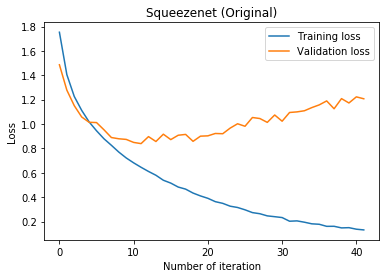

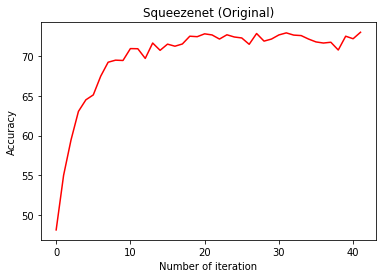

Mean time per epoch 34.21395397599998 seconds
Best accuracy: 73.02  Best training loss: 0.13145054809655995  Best validation loss: 0.8394116374850273


In [0]:
  # visualization loss 
plt.plot(iteration_list,loss_list, label='Training loss')
plt.plot(iteration_list,loss_list_test, label='Validation loss')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Squeezenet (Original)")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("Squeezenet (Original)")
plt.show()

print(f"Mean time per epoch {np.mean(execution_time)} seconds") # returns time in sec 
print(f"Best accuracy: {best_acc}  Best training loss: {min(loss_list)}  Best validation loss: {min(loss_list_test)}")


In [0]:
print(str(iteration_list))
print(str(loss_list))
print(str(loss_list_test))
print(str(accuracy_list))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
[1.7530029838085175, 1.4054186010956764, 1.2262543530464172, 1.11206821256876, 1.0174993271231652, 0.9446473330259323, 0.8791469852030277, 0.8256531829833984, 0.7699933918714523, 0.7217608823180198, 0.6816095776855946, 0.6451221434772014, 0.6110327849388123, 0.5798243822902441, 0.5389030829966068, 0.5155020115673542, 0.4831509550511837, 0.4661193103641272, 0.43383051754534246, 0.4102742100507021, 0.39068286488950255, 0.3632538733780384, 0.3494019308239222, 0.3261039031147957, 0.31544896789640187, 0.29637291316315534, 0.2734553378075361, 0.2642798228003085, 0.24665471294894814, 0.23994675743952393, 0.23280917739868165, 0.20280317642912268, 0.20556166363880038, 0.1947154118269682, 0.18145877598784865, 0.1777478300817311, 0.160825694732368, 0.16113818064332008, 0.14800657242536544, 0.14994053562451154, 0.13738201677799225, 0.1314505

## squeeze net (batch normed)

In [0]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo

__all__ = ['SqueezeNet', 'squeezenet1_0', 'squeezenet1_1']

model_urls = {
    'squeezenet1_0': 'https://download.pytorch.org/models/squeezenet1_0-a815701f.pth',
    'squeezenet1_1': 'https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth',
}


class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.bns1 = nn.BatchNorm2d(squeeze_planes)

        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.bne1 = nn.BatchNorm2d(expand1x1_planes)

        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        self.bne3 = nn.BatchNorm2d(expand3x3_planes)

        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.bns1(self.squeeze(x)))


        return torch.cat([
            self.expand1x1_activation(self.bne1(self.expand1x1(x))),
            self.expand3x3_activation(self.bne3(self.expand3x3(x)))
        ], 1)


class SqueezeNet(nn.Module):

    def __init__(self, version='1_0', num_classes=1000):
        super(SqueezeNet, self).__init__()
        self.num_classes = num_classes
        if version == '1_0':
            self.features = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=7, stride=2),
                nn.BatchNorm2d(96),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 16, 64, 64),
                Fire(128, 16, 64, 64),
                Fire(128, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 32, 128, 128),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(512, 64, 256, 256),
            )
        elif version == '1_1':
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(64, 16, 64, 64),
                Fire(128, 16, 64, 64),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(128, 32, 128, 128),
                Fire(256, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                Fire(512, 64, 256, 256),
            )
        else:
            # FIXME: Is this needed? SqueezeNet should only be called from the
            # FIXME: squeezenet1_x() functions
            # FIXME: This checking is not done for the other models
            raise ValueError("Unsupported SqueezeNet version {version}:"
                             "1_0 or 1_1 expected".format(version=version))

        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.BatchNorm2d(self.num_classes),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return torch.flatten(x, 1)


def _squeezenet(version, pretrained, progress, **kwargs):
    model = SqueezeNet(version, **kwargs)
    if pretrained:
        arch = 'squeezenet' + version
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def squeezenet1_0(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet model architecture from the `"SqueezeNet: AlexNet-level
    accuracy with 50x fewer parameters and <0.5MB model size"
    <https://arxiv.org/abs/1602.07360>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_0', pretrained, progress, **kwargs)


def squeezenet1_1(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet 1.1 model from the `official SqueezeNet repo
    <https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1>`_.
    SqueezeNet 1.1 has 2.4x less computation and slightly fewer parameters
    than SqueezeNet 1.0, without sacrificing accuracy.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_1', pretrained, progress, **kwargs)

In [0]:

#change the line below for different models

# import torchvision.models as models
# model = models.squeezenet1_0(pretrained=True)

model = squeezenet1_0(num_classes=10)

# print(model)

model = model.to(device=device, dtype=torch.float)

# Cross Entropy Loss 
error = CrossEntropyLoss().to(device=device, dtype=torch.float)

#Optimizer
learning_rate = 0.1
optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=learning_rate)

#Optimizer adam
# learning_rate = 0.04
# optimizer = Adam(model.parameters(), lr=learning_rate)
# optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, dampening=0, weight_decay=0.0002, nesterov=False)
#optimizer = SGD(model.parameters(), lr=learning_rate)

#adaptive learning rate
# how many epoc before decreasing learning rate
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [0]:
#load trained dictionary
PATH = '/content/squeezenet_loss.pth'
model.load_state_dict(torch.load(PATH))

In [0]:
%%time
#training/testing
loss_list = []
loss_list_test = []
iteration_list = []
accuracy_list = []
# execution time checking
execution_time = []

PATH = '/content/squeezenet_acc.pth'
best_model_wts = copy.deepcopy(model.state_dict())
PATH2 = '/content/squeezenet_loss.pth'
best_model_loss = copy.deepcopy(model.state_dict())

#PATH = '/content/modified_mnist_effb2_pre_original_latest.pth'
#latest_model_wts = copy.deepcopy(model.state_dict())
best_loss = float("inf")
best_acc = 0.0
#set number of epochs 
num_epochs = 100
for epoch in range(num_epochs):
    #print("\nTrain Epoch {}: lr = {}".format(epoch, exp_lr_scheduler.get_lr()[0]))
    print("\nTrain Epoch {}: lr = {}".format(epoch,learning_rate))

    start = timeit.default_timer()
    loss_list.append(train(epoch, train_loader, model, error, optimizer, batch_size))
    loss_test, accuracy = test(test_loader, model, error, batch_size)
    stop = timeit.default_timer()
    etime = stop - start
    execution_time.append(etime)

    loss_list_test.append(loss_test)
    accuracy_list.append(accuracy)
    iteration_list.append(epoch)
    #exp_lr_scheduler.step()

    #saving model with best acc 
    if accuracy > best_acc:
      print(f"Better accuracy at Epoch {epoch}: accuracy = {accuracy}%")
      best_acc = accuracy
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(best_model_wts, PATH)
    #saving model with best loss
    if loss_test < best_loss:
      print(f"Better loss at Epoch {epoch}: loss = {loss_test}%")
      best_loss = loss_test
      best_model_loss = copy.deepcopy(model.state_dict())
      torch.save(best_model_loss, PATH2)
#load model
# model = Net()
# model.load_state_dict(torch.load(PATH))


Train Epoch 0: lr = 0.1
Train Epoch: 0 [5000/50000 (10%)]	Train Loss: 2.254989
Train Epoch: 0 [10000/50000 (20%)]	Train Loss: 2.008565
Train Epoch: 0 [15000/50000 (30%)]	Train Loss: 1.891325
Train Epoch: 0 [20000/50000 (40%)]	Train Loss: 1.833889
Train Epoch: 0 [25000/50000 (50%)]	Train Loss: 1.778979
Train Epoch: 0 [30000/50000 (60%)]	Train Loss: 1.760738
Train Epoch: 0 [35000/50000 (70%)]	Train Loss: 1.696670
Train Epoch: 0 [40000/50000 (80%)]	Train Loss: 1.656897
Train Epoch: 0 [45000/50000 (90%)]	Train Loss: 1.603798

Test set: Test loss: 1.5248, Accuracy: 2335/5000 (47%)

Better accuracy at Epoch 0: accuracy = 46.7%
Better loss at Epoch 0: loss = 1.5248075771331793%

Train Epoch 1: lr = 0.1
Train Epoch: 1 [5000/50000 (10%)]	Train Loss: 1.544287
Train Epoch: 1 [10000/50000 (20%)]	Train Loss: 1.523842
Train Epoch: 1 [15000/50000 (30%)]	Train Loss: 1.489133
Train Epoch: 1 [20000/50000 (40%)]	Train Loss: 1.446984
Train Epoch: 1 [25000/50000 (50%)]	Train Loss: 1.466959
Train Epoch: 1 

KeyboardInterrupt: ignored

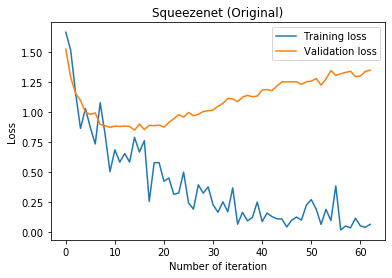

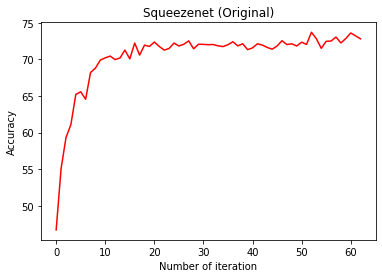

Mean time per epoch 37.18875810782537 seconds
Best accuracy: 73.72  Best training loss: 0.020710553973913193  Best validation loss: 0.850758360028267


In [0]:
  # visualization loss 
plt.plot(iteration_list,loss_list, label='Training loss')
plt.plot(iteration_list,loss_list_test, label='Validation loss')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Squeezenet (Original)")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("Squeezenet (Original)")
plt.show()

print(f"Mean time per epoch {np.mean(execution_time)} seconds") # returns time in sec 
print(f"Best accuracy: {best_acc}  Best training loss: {min(loss_list)}  Best validation loss: {min(loss_list_test)}")


In [0]:
print(str(iteration_list))
print(str(loss_list))
print(str(loss_list_test))
print(str(accuracy_list))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]
[1.6649585962295532, 1.513968825340271, 1.158576250076294, 0.8647364974021912, 1.0302220582962036, 0.8714985847473145, 0.7354030609130859, 1.0790632963180542, 0.8174920678138733, 0.5057325959205627, 0.686977744102478, 0.5849288702011108, 0.6560469269752502, 0.5848870873451233, 0.7902881503105164, 0.6683538556098938, 0.7632835507392883, 0.2575758993625641, 0.5791089534759521, 0.5804818868637085, 0.42531609535217285, 0.4527164399623871, 0.31680378317832947, 0.3272586166858673, 0.5007224678993225, 0.2454374134540558, 0.19363906979560852, 0.3956010341644287, 0.3267644941806793, 0.3780527114868164, 0.2296539843082428, 0.16767479479312897, 0.25428780913352966, 0.17200492322444916, 0.37030982971191406, 0.06840630620718002, 0.1671062409877777, 0.096054814

## squeeze net (batch normed in fire module)

In [0]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo

__all__ = ['SqueezeNet', 'squeezenet1_0', 'squeezenet1_1']

model_urls = {
    'squeezenet1_0': 'https://download.pytorch.org/models/squeezenet1_0-a815701f.pth',
    'squeezenet1_1': 'https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth',
}


class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.bns1 = nn.BatchNorm2d(squeeze_planes)

        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.bne1 = nn.BatchNorm2d(expand1x1_planes)

        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        self.bne3 = nn.BatchNorm2d(expand3x3_planes)

        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.bns1(self.squeeze(x)))


        return torch.cat([
            self.expand1x1_activation(self.bne1(self.expand1x1(x))),
            self.expand3x3_activation(self.bne3(self.expand3x3(x)))
        ], 1)


class SqueezeNet(nn.Module):

    def __init__(self, version='1_0', num_classes=1000):
        super(SqueezeNet, self).__init__()
        self.num_classes = num_classes
        if version == '1_0':
            self.features = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=7, stride=2),
                #nn.BatchNorm2d(96),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 16, 64, 64),
                Fire(128, 16, 64, 64),
                Fire(128, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 32, 128, 128),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(512, 64, 256, 256),
            )
        elif version == '1_1':
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(64, 16, 64, 64),
                Fire(128, 16, 64, 64),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(128, 32, 128, 128),
                Fire(256, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                Fire(512, 64, 256, 256),
            )
        else:
            # FIXME: Is this needed? SqueezeNet should only be called from the
            # FIXME: squeezenet1_x() functions
            # FIXME: This checking is not done for the other models
            raise ValueError("Unsupported SqueezeNet version {version}:"
                             "1_0 or 1_1 expected".format(version=version))

        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.BatchNorm2d(self.num_classes),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return torch.flatten(x, 1)


def _squeezenet(version, pretrained, progress, **kwargs):
    model = SqueezeNet(version, **kwargs)
    if pretrained:
        arch = 'squeezenet' + version
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def squeezenet1_0(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet model architecture from the `"SqueezeNet: AlexNet-level
    accuracy with 50x fewer parameters and <0.5MB model size"
    <https://arxiv.org/abs/1602.07360>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_0', pretrained, progress, **kwargs)


def squeezenet1_1(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet 1.1 model from the `official SqueezeNet repo
    <https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1>`_.
    SqueezeNet 1.1 has 2.4x less computation and slightly fewer parameters
    than SqueezeNet 1.0, without sacrificing accuracy.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_1', pretrained, progress, **kwargs)

In [0]:

#change the line below for different models

# import torchvision.models as models
# model = models.squeezenet1_0(pretrained=True)

model = squeezenet1_0(num_classes=10)

# print(model)

model = model.to(device=device, dtype=torch.float)

# Cross Entropy Loss 
error = CrossEntropyLoss().to(device=device, dtype=torch.float)

#Optimizer
learning_rate = 0.1
optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=learning_rate)

#Optimizer adam
# learning_rate = 0.04
# optimizer = Adam(model.parameters(), lr=learning_rate)
# optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, dampening=0, weight_decay=0.0002, nesterov=False)
#optimizer = SGD(model.parameters(), lr=learning_rate)

#adaptive learning rate
# how many epoc before decreasing learning rate
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [0]:
#load trained dictionary
PATH = '/content/squeezenet_loss.pth'
model.load_state_dict(torch.load(PATH))

In [0]:
%%time
#training/testing
loss_list = []
loss_list_test = []
iteration_list = []
accuracy_list = []
# execution time checking
execution_time = []

PATH = '/content/squeezenet_acc.pth'
best_model_wts = copy.deepcopy(model.state_dict())
PATH2 = '/content/squeezenet_loss.pth'
best_model_loss = copy.deepcopy(model.state_dict())

#PATH = '/content/modified_mnist_effb2_pre_original_latest.pth'
#latest_model_wts = copy.deepcopy(model.state_dict())
best_loss = float("inf")
best_acc = 0.0
#set number of epochs 
num_epochs = 100
for epoch in range(num_epochs):
    #print("\nTrain Epoch {}: lr = {}".format(epoch, exp_lr_scheduler.get_lr()[0]))
    print("\nTrain Epoch {}: lr = {}".format(epoch,learning_rate))

    start = timeit.default_timer()
    loss_list.append(train(epoch, train_loader, model, error, optimizer, batch_size))
    loss_test, accuracy = test(test_loader, model, error, batch_size)
    stop = timeit.default_timer()
    etime = stop - start
    execution_time.append(etime)

    loss_list_test.append(loss_test)
    accuracy_list.append(accuracy)
    iteration_list.append(epoch)
    #exp_lr_scheduler.step()

    #saving model with best acc 
    if accuracy > best_acc:
      print(f"Better accuracy at Epoch {epoch}: accuracy = {accuracy}%")
      best_acc = accuracy
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(best_model_wts, PATH)
    #saving model with best loss
    if loss_test < best_loss:
      print(f"Better loss at Epoch {epoch}: loss = {loss_test}%")
      best_loss = loss_test
      best_model_loss = copy.deepcopy(model.state_dict())
      torch.save(best_model_loss, PATH2)
#load model
# model = Net()
# model.load_state_dict(torch.load(PATH))


Train Epoch 0: lr = 0.1
Train Epoch: 0 [5000/50000 (10%)]	Train Loss: 2.275788
Train Epoch: 0 [10000/50000 (20%)]	Train Loss: 2.035182
Train Epoch: 0 [15000/50000 (30%)]	Train Loss: 1.900537
Train Epoch: 0 [20000/50000 (40%)]	Train Loss: 1.819399
Train Epoch: 0 [25000/50000 (50%)]	Train Loss: 1.787741
Train Epoch: 0 [30000/50000 (60%)]	Train Loss: 1.740649
Train Epoch: 0 [35000/50000 (70%)]	Train Loss: 1.682548
Train Epoch: 0 [40000/50000 (80%)]	Train Loss: 1.656160
Train Epoch: 0 [45000/50000 (90%)]	Train Loss: 1.648021

Test set: Test loss: 1.5243, Accuracy: 2279/5000 (46%)

Better accuracy at Epoch 0: accuracy = 45.58%
Better loss at Epoch 0: loss = 1.5243100726604462%

Train Epoch 1: lr = 0.1
Train Epoch: 1 [5000/50000 (10%)]	Train Loss: 1.571942
Train Epoch: 1 [10000/50000 (20%)]	Train Loss: 1.574569
Train Epoch: 1 [15000/50000 (30%)]	Train Loss: 1.493208
Train Epoch: 1 [20000/50000 (40%)]	Train Loss: 1.480752
Train Epoch: 1 [25000/50000 (50%)]	Train Loss: 1.469916
Train Epoch: 1

KeyboardInterrupt: ignored

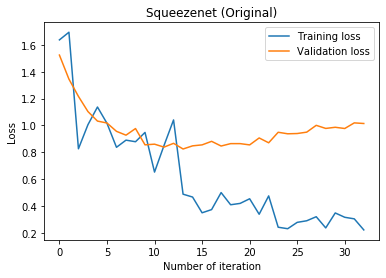

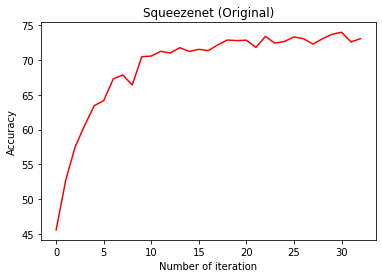

Mean time per epoch 34.52487746060626 seconds
Best accuracy: 74.0  Best training loss: 0.2210252732038498  Best validation loss: 0.8242081516981126


In [0]:
  # visualization loss 
plt.plot(iteration_list,loss_list, label='Training loss')
plt.plot(iteration_list,loss_list_test, label='Validation loss')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Squeezenet (Original)")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("Squeezenet (Original)")
plt.show()

print(f"Mean time per epoch {np.mean(execution_time)} seconds") # returns time in sec 
print(f"Best accuracy: {best_acc}  Best training loss: {min(loss_list)}  Best validation loss: {min(loss_list_test)}")


In [0]:
print(str(iteration_list))
print(str(loss_list))
print(str(loss_list_test))
print(str(accuracy_list))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
[1.6375187635421753, 1.6945152282714844, 0.8258227705955505, 1.0054441690444946, 1.1372429132461548, 1.0158512592315674, 0.8369529843330383, 0.8901993036270142, 0.878383457660675, 0.9477666616439819, 0.652128279209137, 0.8509068489074707, 1.040832281112671, 0.4873678982257843, 0.4660559892654419, 0.34873801469802856, 0.37246420979499817, 0.49928709864616394, 0.40859001874923706, 0.4186958074569702, 0.45320525765419006, 0.33774489164352417, 0.4745442867279053, 0.24109862744808197, 0.22999568283557892, 0.27735060453414917, 0.2891758978366852, 0.31933245062828064, 0.2360219955444336, 0.34744197130203247, 0.31519293785095215, 0.30355703830718994, 0.2210252732038498]
[1.5243100726604462, 1.3452409231662752, 1.2163545393943787, 1.1031716549396522, 1.0323396480083469, 1.0179479336738584, 0.9558254581689839, 0.9272959387302401, 0.9766502523422239, 0.8551315557956698, 0.860

## squeeze net (batch normed in main)

In [0]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo

__all__ = ['SqueezeNet', 'squeezenet1_0', 'squeezenet1_1']

model_urls = {
    'squeezenet1_0': 'https://download.pytorch.org/models/squeezenet1_0-a815701f.pth',
    'squeezenet1_1': 'https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth',
}


class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)

        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)

        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)

        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.squeeze(x))

        return torch.cat([
            self.expand1x1_activation(self.expand1x1(x)),
            self.expand3x3_activation(self.expand3x3(x))
        ], 1)


class SqueezeNet(nn.Module):

    def __init__(self, version='1_0', num_classes=1000):
        super(SqueezeNet, self).__init__()
        self.num_classes = num_classes
        if version == '1_0':
            self.features = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=7, stride=2),
                nn.BatchNorm2d(96),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 16, 64, 64),
                Fire(128, 16, 64, 64),
                Fire(128, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 32, 128, 128),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(512, 64, 256, 256),
            )
        elif version == '1_1':
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(64, 16, 64, 64),
                Fire(128, 16, 64, 64),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(128, 32, 128, 128),
                Fire(256, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                Fire(512, 64, 256, 256),
            )
        else:
            # FIXME: Is this needed? SqueezeNet should only be called from the
            # FIXME: squeezenet1_x() functions
            # FIXME: This checking is not done for the other models
            raise ValueError("Unsupported SqueezeNet version {version}:"
                             "1_0 or 1_1 expected".format(version=version))

        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.BatchNorm2d(self.num_classes),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return torch.flatten(x, 1)


def _squeezenet(version, pretrained, progress, **kwargs):
    model = SqueezeNet(version, **kwargs)
    if pretrained:
        arch = 'squeezenet' + version
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def squeezenet1_0(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet model architecture from the `"SqueezeNet: AlexNet-level
    accuracy with 50x fewer parameters and <0.5MB model size"
    <https://arxiv.org/abs/1602.07360>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_0', pretrained, progress, **kwargs)


def squeezenet1_1(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet 1.1 model from the `official SqueezeNet repo
    <https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1>`_.
    SqueezeNet 1.1 has 2.4x less computation and slightly fewer parameters
    than SqueezeNet 1.0, without sacrificing accuracy.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_1', pretrained, progress, **kwargs)

In [0]:

#change the line below for different models

# import torchvision.models as models
# model = models.squeezenet1_0(pretrained=True)

model = squeezenet1_0(num_classes=10)

# print(model)

model = model.to(device=device, dtype=torch.float)

# Cross Entropy Loss 
error = CrossEntropyLoss().to(device=device, dtype=torch.float)

#Optimizer
learning_rate = 0.1
optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=learning_rate)

#Optimizer adam
# learning_rate = 0.04
# optimizer = Adam(model.parameters(), lr=learning_rate)
# optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, dampening=0, weight_decay=0.0002, nesterov=False)
#optimizer = SGD(model.parameters(), lr=learning_rate)

#adaptive learning rate
# how many epoc before decreasing learning rate
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [0]:
#load trained dictionary
PATH = '/content/squeezenet_loss.pth'
model.load_state_dict(torch.load(PATH))

In [0]:
%%time
#training/testing
loss_list = []
loss_list_test = []
iteration_list = []
accuracy_list = []
# execution time checking
execution_time = []

PATH = '/content/squeezenet_acc.pth'
best_model_wts = copy.deepcopy(model.state_dict())
PATH2 = '/content/squeezenet_loss.pth'
best_model_loss = copy.deepcopy(model.state_dict())

#PATH = '/content/modified_mnist_effb2_pre_original_latest.pth'
#latest_model_wts = copy.deepcopy(model.state_dict())
best_loss = float("inf")
best_acc = 0.0
#set number of epochs 
num_epochs = 100
for epoch in range(num_epochs):
    #print("\nTrain Epoch {}: lr = {}".format(epoch, exp_lr_scheduler.get_lr()[0]))
    print("\nTrain Epoch {}: lr = {}".format(epoch,learning_rate))

    start = timeit.default_timer()
    loss_list.append(train(epoch, train_loader, model, error, optimizer, batch_size))
    loss_test, accuracy = test(test_loader, model, error, batch_size)
    stop = timeit.default_timer()
    etime = stop - start
    execution_time.append(etime)

    loss_list_test.append(loss_test)
    accuracy_list.append(accuracy)
    iteration_list.append(epoch)
    #exp_lr_scheduler.step()

    #saving model with best acc 
    if accuracy > best_acc:
      print(f"Better accuracy at Epoch {epoch}: accuracy = {accuracy}%")
      best_acc = accuracy
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(best_model_wts, PATH)
    #saving model with best loss
    if loss_test < best_loss:
      print(f"Better loss at Epoch {epoch}: loss = {loss_test}%")
      best_loss = loss_test
      best_model_loss = copy.deepcopy(model.state_dict())
      torch.save(best_model_loss, PATH2)
#load model
# model = Net()
# model.load_state_dict(torch.load(PATH))


Train Epoch 0: lr = 0.1
Train Epoch: 0 [5000/50000 (10%)]	Train Loss: 2.322997
Train Epoch: 0 [10000/50000 (20%)]	Train Loss: 2.302584
Train Epoch: 0 [15000/50000 (30%)]	Train Loss: 2.302584
Train Epoch: 0 [20000/50000 (40%)]	Train Loss: 2.302584
Train Epoch: 0 [25000/50000 (50%)]	Train Loss: 2.302584
Train Epoch: 0 [30000/50000 (60%)]	Train Loss: 2.302584
Train Epoch: 0 [35000/50000 (70%)]	Train Loss: 2.302584
Train Epoch: 0 [40000/50000 (80%)]	Train Loss: 2.302584
Train Epoch: 0 [45000/50000 (90%)]	Train Loss: 2.302572

Test set: Test loss: 2.3026, Accuracy: 480/5000 (10%)

Better accuracy at Epoch 0: accuracy = 9.6%
Better loss at Epoch 0: loss = 2.3025844097137442%

Train Epoch 1: lr = 0.1
Train Epoch: 1 [5000/50000 (10%)]	Train Loss: 2.325610
Train Epoch: 1 [10000/50000 (20%)]	Train Loss: 2.302584
Train Epoch: 1 [15000/50000 (30%)]	Train Loss: 2.302584
Train Epoch: 1 [20000/50000 (40%)]	Train Loss: 2.302584
Train Epoch: 1 [25000/50000 (50%)]	Train Loss: 2.302584
Train Epoch: 1 [3

KeyboardInterrupt: ignored

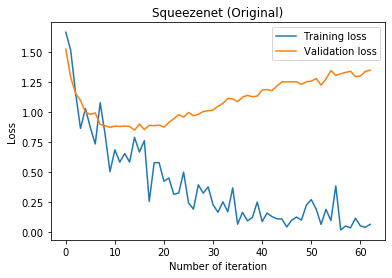

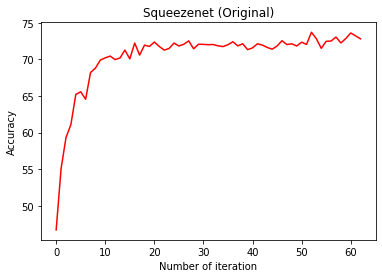

Mean time per epoch 37.18875810782537 seconds
Best accuracy: 73.72  Best training loss: 0.020710553973913193  Best validation loss: 0.850758360028267


In [0]:
  # visualization loss 
plt.plot(iteration_list,loss_list, label='Training loss')
plt.plot(iteration_list,loss_list_test, label='Validation loss')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Squeezenet (Original)")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("Squeezenet (Original)")
plt.show()

print(f"Mean time per epoch {np.mean(execution_time)} seconds") # returns time in sec 
print(f"Best accuracy: {best_acc}  Best training loss: {min(loss_list)}  Best validation loss: {min(loss_list_test)}")


In [0]:
print(str(iteration_list))
print(str(loss_list))
print(str(loss_list_test))
print(str(accuracy_list))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]
[1.6649585962295532, 1.513968825340271, 1.158576250076294, 0.8647364974021912, 1.0302220582962036, 0.8714985847473145, 0.7354030609130859, 1.0790632963180542, 0.8174920678138733, 0.5057325959205627, 0.686977744102478, 0.5849288702011108, 0.6560469269752502, 0.5848870873451233, 0.7902881503105164, 0.6683538556098938, 0.7632835507392883, 0.2575758993625641, 0.5791089534759521, 0.5804818868637085, 0.42531609535217285, 0.4527164399623871, 0.31680378317832947, 0.3272586166858673, 0.5007224678993225, 0.2454374134540558, 0.19363906979560852, 0.3956010341644287, 0.3267644941806793, 0.3780527114868164, 0.2296539843082428, 0.16767479479312897, 0.25428780913352966, 0.17200492322444916, 0.37030982971191406, 0.06840630620718002, 0.1671062409877777, 0.096054814

## squeeze net (batch normed) (removed 2 fire layer)

In [0]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo

__all__ = ['SqueezeNet', 'squeezenet1_0', 'squeezenet1_1']

model_urls = {
    'squeezenet1_0': 'https://download.pytorch.org/models/squeezenet1_0-a815701f.pth',
    'squeezenet1_1': 'https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth',
}


class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.bns1 = nn.BatchNorm2d(squeeze_planes)

        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.bne1 = nn.BatchNorm2d(expand1x1_planes)

        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        self.bne3 = nn.BatchNorm2d(expand3x3_planes)

        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.bns1(self.squeeze(x)))


        return torch.cat([
            self.expand1x1_activation(self.bne1(self.expand1x1(x))),
            self.expand3x3_activation(self.bne3(self.expand3x3(x)))
        ], 1)


class SqueezeNet(nn.Module):

    def __init__(self, version='1_0', num_classes=1000):
        super(SqueezeNet, self).__init__()
        self.num_classes = num_classes
        if version == '1_0':
            self.features = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=7, stride=2),
                nn.BatchNorm2d(96),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 16, 64, 64),
                Fire(128, 16, 64, 64),
                Fire(128, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 32, 128, 128),
                Fire(256, 48, 192, 192),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(384, 48, 192, 192),
            )
        elif version == '1_1':
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(64, 16, 64, 64),
                Fire(128, 16, 64, 64),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(128, 32, 128, 128),
                Fire(256, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                Fire(512, 64, 256, 256),
            )
        else:
            # FIXME: Is this needed? SqueezeNet should only be called from the
            # FIXME: squeezenet1_x() functions
            # FIXME: This checking is not done for the other models
            raise ValueError("Unsupported SqueezeNet version {version}:"
                             "1_0 or 1_1 expected".format(version=version))

        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(384, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.BatchNorm2d(self.num_classes),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return torch.flatten(x, 1)


def _squeezenet(version, pretrained, progress, **kwargs):
    model = SqueezeNet(version, **kwargs)
    if pretrained:
        arch = 'squeezenet' + version
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def squeezenet1_0(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet model architecture from the `"SqueezeNet: AlexNet-level
    accuracy with 50x fewer parameters and <0.5MB model size"
    <https://arxiv.org/abs/1602.07360>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_0', pretrained, progress, **kwargs)


def squeezenet1_1(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet 1.1 model from the `official SqueezeNet repo
    <https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1>`_.
    SqueezeNet 1.1 has 2.4x less computation and slightly fewer parameters
    than SqueezeNet 1.0, without sacrificing accuracy.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_1', pretrained, progress, **kwargs)

In [0]:

#change the line below for different models

# import torchvision.models as models
# model = models.squeezenet1_0(pretrained=True)

model = squeezenet1_0(num_classes=10)

# print(model)

model = model.to(device=device, dtype=torch.float)

# Cross Entropy Loss 
error = CrossEntropyLoss().to(device=device, dtype=torch.float)

#Optimizer
learning_rate = 0.1
optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=learning_rate)

#Optimizer adam
# learning_rate = 0.04
# optimizer = Adam(model.parameters(), lr=learning_rate)
# optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, dampening=0, weight_decay=0.0002, nesterov=False)
#optimizer = SGD(model.parameters(), lr=learning_rate)

#adaptive learning rate
# how many epoc before decreasing learning rate
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [0]:
#load trained dictionary
PATH = '/content/squeezenet_loss.pth'
model.load_state_dict(torch.load(PATH))

In [0]:
%%time
#training/testing
loss_list = []
loss_list_test = []
iteration_list = []
accuracy_list = []
# execution time checking
execution_time = []

PATH = '/content/squeezenet_acc.pth'
best_model_wts = copy.deepcopy(model.state_dict())
PATH2 = '/content/squeezenet_loss.pth'
best_model_loss = copy.deepcopy(model.state_dict())

#PATH = '/content/modified_mnist_effb2_pre_original_latest.pth'
#latest_model_wts = copy.deepcopy(model.state_dict())
best_loss = float("inf")
best_acc = 0.0
#set number of epochs 
num_epochs = 100
for epoch in range(num_epochs):
    #print("\nTrain Epoch {}: lr = {}".format(epoch, exp_lr_scheduler.get_lr()[0]))
    print("\nTrain Epoch {}: lr = {}".format(epoch,learning_rate))

    start = timeit.default_timer()
    loss_list.append(train(epoch, train_loader, model, error, optimizer, batch_size))
    loss_test, accuracy = test(test_loader, model, error, batch_size)
    stop = timeit.default_timer()
    etime = stop - start
    execution_time.append(etime)

    loss_list_test.append(loss_test)
    accuracy_list.append(accuracy)
    iteration_list.append(epoch)
    #exp_lr_scheduler.step()

    #saving model with best acc 
    if accuracy > best_acc:
      print(f"Better accuracy at Epoch {epoch}: accuracy = {accuracy}%")
      best_acc = accuracy
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(best_model_wts, PATH)
    #saving model with best loss
    if loss_test < best_loss:
      print(f"Better loss at Epoch {epoch}: loss = {loss_test}%")
      best_loss = loss_test
      best_model_loss = copy.deepcopy(model.state_dict())
      torch.save(best_model_loss, PATH2)
#load model
# model = Net()
# model.load_state_dict(torch.load(PATH))


Train Epoch 0: lr = 0.1
Train Epoch: 0 [5000/50000 (10%)]	Train Loss: 2.184084
Train Epoch: 0 [10000/50000 (20%)]	Train Loss: 1.929844
Train Epoch: 0 [15000/50000 (30%)]	Train Loss: 1.819292
Train Epoch: 0 [20000/50000 (40%)]	Train Loss: 1.741655
Train Epoch: 0 [25000/50000 (50%)]	Train Loss: 1.706633
Train Epoch: 0 [30000/50000 (60%)]	Train Loss: 1.681803
Train Epoch: 0 [35000/50000 (70%)]	Train Loss: 1.605038
Train Epoch: 0 [40000/50000 (80%)]	Train Loss: 1.587396
Train Epoch: 0 [45000/50000 (90%)]	Train Loss: 1.529746

Test set: Test loss: 1.4513, Accuracy: 2442/5000 (49%)

Better accuracy at Epoch 0: accuracy = 48.84%
Better loss at Epoch 0: loss = 1.4512908875942232%

Train Epoch 1: lr = 0.1
Train Epoch: 1 [5000/50000 (10%)]	Train Loss: 1.497452
Train Epoch: 1 [10000/50000 (20%)]	Train Loss: 1.466453
Train Epoch: 1 [15000/50000 (30%)]	Train Loss: 1.408232
Train Epoch: 1 [20000/50000 (40%)]	Train Loss: 1.409695
Train Epoch: 1 [25000/50000 (50%)]	Train Loss: 1.386167
Train Epoch: 1

KeyboardInterrupt: ignored

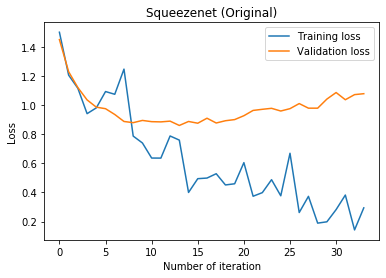

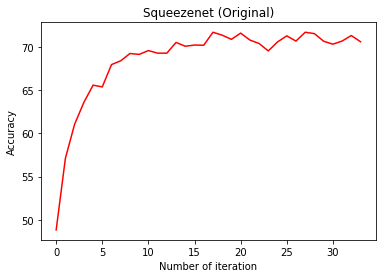

Mean time per epoch 29.232933152676516 seconds
Best accuracy: 71.7  Best training loss: 0.14262917637825012  Best validation loss: 0.8609130695462225


In [0]:
  # visualization loss 
plt.plot(iteration_list,loss_list, label='Training loss')
plt.plot(iteration_list,loss_list_test, label='Validation loss')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Squeezenet (Original)")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("Squeezenet (Original)")
plt.show()

print(f"Mean time per epoch {np.mean(execution_time)} seconds") # returns time in sec 
print(f"Best accuracy: {best_acc}  Best training loss: {min(loss_list)}  Best validation loss: {min(loss_list_test)}")


In [0]:
print(str(iteration_list))
print(str(loss_list))
print(str(loss_list_test))
print(str(accuracy_list))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
[1.5017831325531006, 1.206808090209961, 1.11640465259552, 0.9419748783111572, 0.981797993183136, 1.0940289497375488, 1.0751595497131348, 1.2481834888458252, 0.7877085208892822, 0.740404486656189, 0.6367399096488953, 0.636405885219574, 0.7885422706604004, 0.760142982006073, 0.40021881461143494, 0.49494704604148865, 0.49913445115089417, 0.5290067195892334, 0.45177963376045227, 0.45988601446151733, 0.6052672863006592, 0.3741489052772522, 0.39897099137306213, 0.4879230260848999, 0.3772616684436798, 0.6696516275405884, 0.26215508580207825, 0.3734387159347534, 0.1892787516117096, 0.198419451713562, 0.28234049677848816, 0.3823551535606384, 0.14262917637825012, 0.29431331157684326]
[1.4512908875942232, 1.230314158201218, 1.1212938576936726, 1.0364125180244443, 0.9866232055425642, 0.9760835993289948, 0.9363281095027927, 0.8882440918684006, 0.8800209221243855, 0.89546458

## squeeze skip residuals (batch normed)

In [0]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo

__all__ = ['SqueezeNet', 'squeezenet1_0', 'squeezenet1_1']

model_urls = {
    'squeezenet1_0': 'https://download.pytorch.org/models/squeezenet1_0-a815701f.pth',
    'squeezenet1_1': 'https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth',
}


class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.bns1 = nn.BatchNorm2d(squeeze_planes)

        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.bne1 = nn.BatchNorm2d(expand1x1_planes)

        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        self.bne3 = nn.BatchNorm2d(expand3x3_planes)

        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.bns1(self.squeeze(x)))


        return torch.cat([
            self.expand1x1_activation(self.bne1(self.expand1x1(x))),
            self.expand3x3_activation(self.bne3(self.expand3x3(x)))
        ], 1)


class SqueezeNet(nn.Module):

    def __init__(self, version='1_0', num_classes=1000):
        super(SqueezeNet, self).__init__()
        self.num_classes = num_classes
        # self.features = nn.Sequential(
        #         nn.Conv2d(3, 96, kernel_size=7, stride=2),
        #         nn.ReLU(inplace=True),
        #         nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        #         Fire(96, 16, 64, 64),
        #         Fire(128, 16, 64, 64),
        #         Fire(128, 32, 128, 128),
        #         nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        #         Fire(256, 32, 128, 128),
        #         Fire(256, 48, 192, 192),
        #         Fire(384, 48, 192, 192),
        #         Fire(384, 64, 256, 256),
        #         nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        #         Fire(512, 64, 256, 256),
        # )
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=7, stride=2),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(96, 16, 64, 64),
        )
        self.block1 = nn.Sequential(
            Fire(128, 16, 64, 64),
        )
        self.features2 = nn.Sequential(
            Fire(128, 32, 128, 128),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        )
        self.block2 = nn.Sequential(
            Fire(256, 32, 128, 128),
        )
        self.features3 = nn.Sequential(
            Fire(256, 48, 192, 192),
        )
        self.block3 = nn.Sequential(
            Fire(384, 48, 192, 192),
        )
        self.features4 = nn.Sequential(
            Fire(384, 64, 256, 256),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        
        )
        self.block4 = nn.Sequential(
            Fire(512, 64, 256, 256),
        )
        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.BatchNorm2d(self.num_classes),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features1(x)

        residual1 = x
        x = self.block1(x)
        x += residual1

        x = self.features2(x)

        residual2 = x
        x = self.block2(x)
        x += residual2

        x = self.features3(x)

        residual3 = x
        x = self.block3(x)
        x += residual3

        x = self.features4(x)

        residual4 = x
        x = self.block4(x)
        x += residual4

        x = self.classifier(x)
        return torch.flatten(x, 1)


def _squeezenet(version, pretrained, progress, **kwargs):
    model = SqueezeNet(version, **kwargs)
    if pretrained:
        arch = 'squeezenet' + version
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def squeezenet1_0(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet model architecture from the `"SqueezeNet: AlexNet-level
    accuracy with 50x fewer parameters and <0.5MB model size"
    <https://arxiv.org/abs/1602.07360>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_0', pretrained, progress, **kwargs)


def squeezenet1_1(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet 1.1 model from the `official SqueezeNet repo
    <https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1>`_.
    SqueezeNet 1.1 has 2.4x less computation and slightly fewer parameters
    than SqueezeNet 1.0, without sacrificing accuracy.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_1', pretrained, progress, **kwargs)

In [0]:

#change the line below for different models

# import torchvision.models as models
# model = models.squeezenet1_0(pretrained=True)

model = squeezenet1_0(num_classes=10)

#print(model)

model = model.to(device=device, dtype=torch.float)

# Cross Entropy Loss 
error = CrossEntropyLoss().to(device=device, dtype=torch.float)

#Optimizer
learning_rate = 0.1
optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=learning_rate)

#Optimizer adam
# learning_rate = 0.04
# optimizer = Adam(model.parameters(), lr=learning_rate)
# optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, dampening=0, weight_decay=0.0002, nesterov=False)
# optimizer = SGD(model.parameters(), lr=learning_rate)

#adaptive learning rate
# how many epoc before decreasing learning rate
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [0]:
#load trained dictionary
PATH = '/content/squeezenet_loss.pth'
model.load_state_dict(torch.load(PATH))

In [0]:
%%time
#training/testing
loss_list = []
loss_list_test = []
iteration_list = []
accuracy_list = []
# execution time checking
execution_time = []

PATH = '/content/squeezenet_acc.pth'
best_model_wts = copy.deepcopy(model.state_dict())
PATH2 = '/content/squeezenet_loss.pth'
best_model_loss = copy.deepcopy(model.state_dict())

#PATH = '/content/modified_mnist_effb2_pre_original_latest.pth'
#latest_model_wts = copy.deepcopy(model.state_dict())
best_loss = float("inf")
best_acc = 0.0
#set number of epochs 
num_epochs = 100
for epoch in range(num_epochs):
    #print("\nTrain Epoch {}: lr = {}".format(epoch, exp_lr_scheduler.get_lr()[0]))
    print("\nTrain Epoch {}: lr = {}".format(epoch,learning_rate))

    start = timeit.default_timer()
    loss_list.append(train(epoch, train_loader, model, error, optimizer, batch_size))
    loss_test, accuracy = test(test_loader, model, error, batch_size)
    stop = timeit.default_timer()
    etime = stop - start
    execution_time.append(etime)

    loss_list_test.append(loss_test)
    accuracy_list.append(accuracy)
    iteration_list.append(epoch)
    #exp_lr_scheduler.step()

    #saving model with best acc 
    if accuracy > best_acc:
      print(f"Better accuracy at Epoch {epoch}: accuracy = {accuracy}%")
      best_acc = accuracy
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(best_model_wts, PATH)
    #saving model with best loss
    if loss_test < best_loss:
      print(f"Better loss at Epoch {epoch}: loss = {loss_test}%")
      best_loss = loss_test
      best_model_loss = copy.deepcopy(model.state_dict())
      torch.save(best_model_loss, PATH2)
#load model
# model = Net()
# model.load_state_dict(torch.load(PATH))


Train Epoch 0: lr = 0.1
Train Epoch: 0 [5000/50000 (10%)]	Train Loss: 2.222965
Train Epoch: 0 [10000/50000 (20%)]	Train Loss: 1.939407
Train Epoch: 0 [15000/50000 (30%)]	Train Loss: 1.807879
Train Epoch: 0 [20000/50000 (40%)]	Train Loss: 1.728481
Train Epoch: 0 [25000/50000 (50%)]	Train Loss: 1.652416
Train Epoch: 0 [30000/50000 (60%)]	Train Loss: 1.607269
Train Epoch: 0 [35000/50000 (70%)]	Train Loss: 1.571071
Train Epoch: 0 [40000/50000 (80%)]	Train Loss: 1.504610
Train Epoch: 0 [45000/50000 (90%)]	Train Loss: 1.455477

Test set: Test loss: 1.3356, Accuracy: 2731/5000 (55%)

Better accuracy at Epoch 0: accuracy = 54.62%
Better loss at Epoch 0: loss = 1.3355705612897872%

Train Epoch 1: lr = 0.1
Train Epoch: 1 [5000/50000 (10%)]	Train Loss: 1.356978
Train Epoch: 1 [10000/50000 (20%)]	Train Loss: 1.368610
Train Epoch: 1 [15000/50000 (30%)]	Train Loss: 1.343431
Train Epoch: 1 [20000/50000 (40%)]	Train Loss: 1.323758
Train Epoch: 1 [25000/50000 (50%)]	Train Loss: 1.314335
Train Epoch: 1

KeyboardInterrupt: ignored

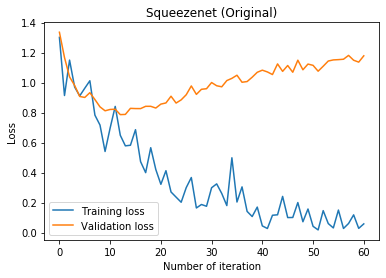

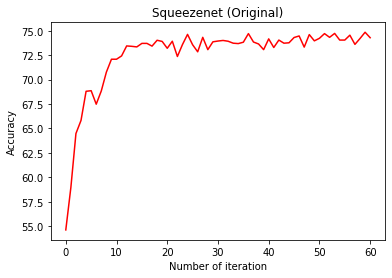

Mean time per epoch 37.710669455885224 seconds
Best accuracy: 74.84  Best training loss: 0.017938118427991867  Best validation loss: 0.7864684224128718


In [0]:
  # visualization loss 
plt.plot(iteration_list,loss_list, label='Training loss')
plt.plot(iteration_list,loss_list_test, label='Validation loss')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Squeezenet (Original)")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("Squeezenet (Original)")
plt.show()

print(f"Mean time per epoch {np.mean(execution_time)} seconds") # returns time in sec 
print(f"Best accuracy: {best_acc}  Best training loss: {min(loss_list)}  Best validation loss: {min(loss_list_test)}")


In [0]:
print(str(iteration_list))
print(str(loss_list))
print(str(loss_list_test))
print(str(accuracy_list))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
[1.3012902736663818, 0.9138363003730774, 1.1499232053756714, 0.9705672264099121, 0.9113034009933472, 0.9625198841094971, 1.0122523307800293, 0.7827902436256409, 0.7167970538139343, 0.5407299995422363, 0.6973969340324402, 0.8412118554115295, 0.6487481594085693, 0.5783197283744812, 0.5823440551757812, 0.686017632484436, 0.4730595350265503, 0.39966002106666565, 0.5659844875335693, 0.42069530487060547, 0.3219113051891327, 0.4126985967159271, 0.27082499861717224, 0.23645071685314178, 0.20238718390464783, 0.2999936044216156, 0.367158979177475, 0.16423523426055908, 0.18740898370742798, 0.17556366324424744, 0.29907235503196716, 0.32482269406318665, 0.26091331243515015, 0.18017655611038208, 0.49880069494247437, 0.20392565429210663, 0.3048231601715088, 0.1413597613

## squeeze skip residuals (batch normed) (removed 2 fire layer)

In [0]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo

__all__ = ['SqueezeNet', 'squeezenet1_0', 'squeezenet1_1']

model_urls = {
    'squeezenet1_0': 'https://download.pytorch.org/models/squeezenet1_0-a815701f.pth',
    'squeezenet1_1': 'https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth',
}


class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.bns1 = nn.BatchNorm2d(squeeze_planes)

        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.bne1 = nn.BatchNorm2d(expand1x1_planes)

        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        self.bne3 = nn.BatchNorm2d(expand3x3_planes)

        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.bns1(self.squeeze(x)))


        return torch.cat([
            self.expand1x1_activation(self.bne1(self.expand1x1(x))),
            self.expand3x3_activation(self.bne3(self.expand3x3(x)))
        ], 1)


class SqueezeNet(nn.Module):

    def __init__(self, version='1_0', num_classes=1000):
        super(SqueezeNet, self).__init__()
        self.num_classes = num_classes
        # self.features = nn.Sequential(
        #         nn.Conv2d(3, 96, kernel_size=7, stride=2),
        #         nn.ReLU(inplace=True),
        #         nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        #         Fire(96, 16, 64, 64),
        #         Fire(128, 16, 64, 64),
        #         Fire(128, 32, 128, 128),
        #         nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        #         Fire(256, 32, 128, 128),
        #         Fire(256, 48, 192, 192),
        #         Fire(384, 48, 192, 192),
        #         Fire(384, 64, 256, 256),
        #         nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        #         Fire(512, 64, 256, 256),
        # )
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=7, stride=2),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(96, 16, 64, 64),
        )
        self.block1 = nn.Sequential(
            Fire(128, 16, 64, 64),
        )
        self.features2 = nn.Sequential(
            Fire(128, 32, 128, 128),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        )
        self.block2 = nn.Sequential(
            Fire(256, 32, 128, 128),
        )
        self.features3 = nn.Sequential(
            Fire(256, 48, 192, 192),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        )
        self.block3 = nn.Sequential(
            Fire(384, 48, 192, 192),
        )

        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(384, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.BatchNorm2d(self.num_classes),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features1(x)

        residual1 = x
        x = self.block1(x)
        x += residual1

        x = self.features2(x)

        residual2 = x
        x = self.block2(x)
        x += residual2

        x = self.features3(x)

        residual3 = x
        x = self.block3(x)
        x += residual3

        x = self.classifier(x)
        return torch.flatten(x, 1)


def _squeezenet(version, pretrained, progress, **kwargs):
    model = SqueezeNet(version, **kwargs)
    if pretrained:
        arch = 'squeezenet' + version
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def squeezenet1_0(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet model architecture from the `"SqueezeNet: AlexNet-level
    accuracy with 50x fewer parameters and <0.5MB model size"
    <https://arxiv.org/abs/1602.07360>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_0', pretrained, progress, **kwargs)


def squeezenet1_1(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet 1.1 model from the `official SqueezeNet repo
    <https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1>`_.
    SqueezeNet 1.1 has 2.4x less computation and slightly fewer parameters
    than SqueezeNet 1.0, without sacrificing accuracy.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_1', pretrained, progress, **kwargs)

In [0]:

#change the line below for different models

# import torchvision.models as models
# model = models.squeezenet1_0(pretrained=True)

model = squeezenet1_0(num_classes=10)

#print(model)

model = model.to(device=device, dtype=torch.float)

# Cross Entropy Loss 
error = CrossEntropyLoss().to(device=device, dtype=torch.float)

#Optimizer
learning_rate = 0.1
optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=learning_rate)

#Optimizer adam
# learning_rate = 0.04
# optimizer = Adam(model.parameters(), lr=learning_rate)
# optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, dampening=0, weight_decay=0.0002, nesterov=False)
# optimizer = SGD(model.parameters(), lr=learning_rate)

#adaptive learning rate
# how many epoc before decreasing learning rate
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [0]:
#load trained dictionary
PATH = '/content/squeezenet_loss.pth'
model.load_state_dict(torch.load(PATH))

In [0]:
%%time
#training/testing
loss_list = []
loss_list_test = []
iteration_list = []
accuracy_list = []
# execution time checking
execution_time = []

PATH = '/content/squeezenet_acc.pth'
best_model_wts = copy.deepcopy(model.state_dict())
PATH2 = '/content/squeezenet_loss.pth'
best_model_loss = copy.deepcopy(model.state_dict())

#PATH = '/content/modified_mnist_effb2_pre_original_latest.pth'
#latest_model_wts = copy.deepcopy(model.state_dict())
best_loss = float("inf")
best_acc = 0.0
#set number of epochs
num_epochs = 100
for epoch in range(num_epochs):
    #print("\nTrain Epoch {}: lr = {}".format(epoch, exp_lr_scheduler.get_lr()[0]))
    print("\nTrain Epoch {}: lr = {}".format(epoch,learning_rate))

    start = timeit.default_timer()
    loss_list.append(train(epoch, train_loader, model, error, optimizer, batch_size))
    loss_test, accuracy = test(test_loader, model, error, batch_size)
    stop = timeit.default_timer()
    etime = stop - start
    execution_time.append(etime)

    loss_list_test.append(loss_test)
    accuracy_list.append(accuracy)
    iteration_list.append(epoch)
    #exp_lr_scheduler.step()

    #saving model with best acc 
    if accuracy > best_acc:
      print(f"Better accuracy at Epoch {epoch}: accuracy = {accuracy}%")
      best_acc = accuracy
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(best_model_wts, PATH)
    #saving model with best loss
    if loss_test < best_loss:
      print(f"Better loss at Epoch {epoch}: loss = {loss_test}%")
      best_loss = loss_test
      best_model_loss = copy.deepcopy(model.state_dict())
      torch.save(best_model_loss, PATH2)
#load model
# model = Net()
# model.load_state_dict(torch.load(PATH))


Train Epoch 0: lr = 0.1
Train Epoch: 0 [5000/50000 (10%)]	Train Loss: 2.172409
Train Epoch: 0 [10000/50000 (20%)]	Train Loss: 1.857365
Train Epoch: 0 [15000/50000 (30%)]	Train Loss: 1.731581
Train Epoch: 0 [20000/50000 (40%)]	Train Loss: 1.689869
Train Epoch: 0 [25000/50000 (50%)]	Train Loss: 1.616273
Train Epoch: 0 [30000/50000 (60%)]	Train Loss: 1.586640
Train Epoch: 0 [35000/50000 (70%)]	Train Loss: 1.526734
Train Epoch: 0 [40000/50000 (80%)]	Train Loss: 1.475570
Train Epoch: 0 [45000/50000 (90%)]	Train Loss: 1.461383

Test set: Test loss: 1.3331, Accuracy: 2730/5000 (55%)

Better accuracy at Epoch 0: accuracy = 54.6%
Better loss at Epoch 0: loss = 1.3330789291858671%

Train Epoch 1: lr = 0.1
Train Epoch: 1 [5000/50000 (10%)]	Train Loss: 1.392462
Train Epoch: 1 [10000/50000 (20%)]	Train Loss: 1.363953
Train Epoch: 1 [15000/50000 (30%)]	Train Loss: 1.330135
Train Epoch: 1 [20000/50000 (40%)]	Train Loss: 1.296302
Train Epoch: 1 [25000/50000 (50%)]	Train Loss: 1.301391
Train Epoch: 1 

KeyboardInterrupt: ignored

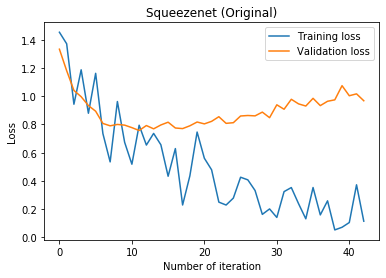

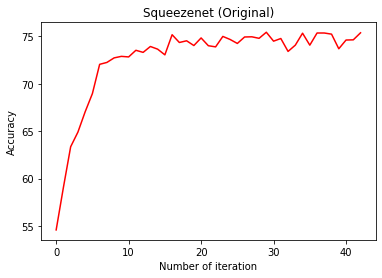

Mean time per epoch 29.94700846632563 seconds
Best accuracy: 75.42  Best training loss: 0.053065892308950424  Best validation loss: 0.7572807887196539


In [0]:
  # visualization loss 
plt.plot(iteration_list,loss_list, label='Training loss')
plt.plot(iteration_list,loss_list_test, label='Validation loss')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Squeezenet (Original)")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("Squeezenet (Original)")
plt.show()

print(f"Mean time per epoch {np.mean(execution_time)} seconds") # returns time in sec 
print(f"Best accuracy: {best_acc}  Best training loss: {min(loss_list)}  Best validation loss: {min(loss_list_test)}")


In [0]:
print(str(iteration_list))
print(str(loss_list))
print(str(loss_list_test))
print(str(accuracy_list))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]
[1.453267216682434, 1.3715189695358276, 0.9433684349060059, 1.1872323751449585, 0.87949538230896, 1.1622833013534546, 0.7353365421295166, 0.5349129438400269, 0.9624720215797424, 0.6736298203468323, 0.5184442400932312, 0.7947319746017456, 0.6541752815246582, 0.7366088628768921, 0.656165361404419, 0.43318861722946167, 0.6291453838348389, 0.22965003550052643, 0.43593940138816833, 0.746277928352356, 0.5608310103416443, 0.47886717319488525, 0.24985690414905548, 0.22937259078025818, 0.27845925092697144, 0.4262692928314209, 0.40763846039772034, 0.33204469084739685, 0.16318246722221375, 0.20171955227851868, 0.14139777421951294, 0.3243696093559265, 0.3531259298324585, 0.23891416192054749, 0.1317232847213745, 0.35347408056259155, 0.15939438343048096, 0.25912660360336304, 0.053065892308950424, 0.07181815803050995, 0.10535714775323868, 0

## squeeze skip residuals (batch normed) (removed 4 fire layer)

In [0]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo

__all__ = ['SqueezeNet', 'squeezenet1_0', 'squeezenet1_1']

model_urls = {
    'squeezenet1_0': 'https://download.pytorch.org/models/squeezenet1_0-a815701f.pth',
    'squeezenet1_1': 'https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth',
}


class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.bns1 = nn.BatchNorm2d(squeeze_planes)

        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.bne1 = nn.BatchNorm2d(expand1x1_planes)

        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        self.bne3 = nn.BatchNorm2d(expand3x3_planes)

        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.bns1(self.squeeze(x)))


        return torch.cat([
            self.expand1x1_activation(self.bne1(self.expand1x1(x))),
            self.expand3x3_activation(self.bne3(self.expand3x3(x)))
        ], 1)


class SqueezeNet(nn.Module):

    def __init__(self, version='1_0', num_classes=1000):
        super(SqueezeNet, self).__init__()
        self.num_classes = num_classes
        # self.features = nn.Sequential(
        #         nn.Conv2d(3, 96, kernel_size=7, stride=2),
        #         nn.ReLU(inplace=True),
        #         nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        #         Fire(96, 16, 64, 64),
        #         Fire(128, 16, 64, 64),
        #         Fire(128, 32, 128, 128),
        #         nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        #         Fire(256, 32, 128, 128),
        #         Fire(256, 48, 192, 192),
        #         Fire(384, 48, 192, 192),
        #         Fire(384, 64, 256, 256),
        #         nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        #         Fire(512, 64, 256, 256),
        # )
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=7, stride=2),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(96, 16, 64, 64),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        )
        self.block1 = nn.Sequential(
            Fire(128, 16, 64, 64),
        )
        self.features2 = nn.Sequential(
            Fire(128, 32, 128, 128),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        )
        self.block2 = nn.Sequential(
            Fire(256, 32, 128, 128),
        )
        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(256, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.BatchNorm2d(self.num_classes),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features1(x)

        residual1 = x
        x = self.block1(x)
        x += residual1

        x = self.features2(x)

        residual2 = x
        x = self.block2(x)
        x += residual2

        x = self.classifier(x)
        return torch.flatten(x, 1)


def _squeezenet(version, pretrained, progress, **kwargs):
    model = SqueezeNet(version, **kwargs)
    if pretrained:
        arch = 'squeezenet' + version
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def squeezenet1_0(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet model architecture from the `"SqueezeNet: AlexNet-level
    accuracy with 50x fewer parameters and <0.5MB model size"
    <https://arxiv.org/abs/1602.07360>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_0', pretrained, progress, **kwargs)


def squeezenet1_1(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet 1.1 model from the `official SqueezeNet repo
    <https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1>`_.
    SqueezeNet 1.1 has 2.4x less computation and slightly fewer parameters
    than SqueezeNet 1.0, without sacrificing accuracy.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_1', pretrained, progress, **kwargs)

In [0]:

#change the line below for different models

# import torchvision.models as models
# model = models.squeezenet1_0(pretrained=True)

model = squeezenet1_0(num_classes=10)

#print(model)

model = model.to(device=device, dtype=torch.float)

# Cross Entropy Loss 
error = CrossEntropyLoss().to(device=device, dtype=torch.float)

#Optimizer
learning_rate = 0.1
optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=learning_rate)

#Optimizer adam
# learning_rate = 0.04
# optimizer = Adam(model.parameters(), lr=learning_rate)
# optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, dampening=0, weight_decay=0.0002, nesterov=False)
# optimizer = SGD(model.parameters(), lr=learning_rate)

#adaptive learning rate
# how many epoc before decreasing learning rate
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [0]:
#load trained dictionary
PATH = '/content/squeezenet_loss.pth'
model.load_state_dict(torch.load(PATH))

In [0]:
%%time
#training/testing
loss_list = []
loss_list_test = []
iteration_list = []
accuracy_list = []
# execution time checking
execution_time = []

PATH = '/content/squeezenet_acc.pth'
best_model_wts = copy.deepcopy(model.state_dict())
PATH2 = '/content/squeezenet_loss.pth'
best_model_loss = copy.deepcopy(model.state_dict())

#PATH = '/content/modified_mnist_effb2_pre_original_latest.pth'
#latest_model_wts = copy.deepcopy(model.state_dict())
best_loss = float("inf")
best_acc = 0.0
#set number of epochs
num_epochs = 100
for epoch in range(num_epochs):
    #print("\nTrain Epoch {}: lr = {}".format(epoch, exp_lr_scheduler.get_lr()[0]))
    print("\nTrain Epoch {}: lr = {}".format(epoch,learning_rate))

    start = timeit.default_timer()
    loss_list.append(train(epoch, train_loader, model, error, optimizer, batch_size))
    loss_test, accuracy = test(test_loader, model, error, batch_size)
    stop = timeit.default_timer()
    etime = stop - start
    execution_time.append(etime)

    loss_list_test.append(loss_test)
    accuracy_list.append(accuracy)
    iteration_list.append(epoch)
    #exp_lr_scheduler.step()

    #saving model with best acc 
    if accuracy > best_acc:
      print(f"Better accuracy at Epoch {epoch}: accuracy = {accuracy}%")
      best_acc = accuracy
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(best_model_wts, PATH)
    #saving model with best loss
    if loss_test < best_loss:
      print(f"Better loss at Epoch {epoch}: loss = {loss_test}%")
      best_loss = loss_test
      best_model_loss = copy.deepcopy(model.state_dict())
      torch.save(best_model_loss, PATH2)
#load model
# model = Net()
# model.load_state_dict(torch.load(PATH))


Train Epoch 0: lr = 0.1
Train Epoch: 0 [5000/50000 (10%)]	Train Loss: 2.144730
Train Epoch: 0 [10000/50000 (20%)]	Train Loss: 1.867799
Train Epoch: 0 [15000/50000 (30%)]	Train Loss: 1.770182
Train Epoch: 0 [20000/50000 (40%)]	Train Loss: 1.710893
Train Epoch: 0 [25000/50000 (50%)]	Train Loss: 1.653480
Train Epoch: 0 [30000/50000 (60%)]	Train Loss: 1.591216
Train Epoch: 0 [35000/50000 (70%)]	Train Loss: 1.539549
Train Epoch: 0 [40000/50000 (80%)]	Train Loss: 1.526393
Train Epoch: 0 [45000/50000 (90%)]	Train Loss: 1.507454

Test set: Test loss: 1.3506, Accuracy: 2675/5000 (54%)

Better accuracy at Epoch 0: accuracy = 53.5%
Better loss at Epoch 0: loss = 1.3505789524316782%

Train Epoch 1: lr = 0.1
Train Epoch: 1 [5000/50000 (10%)]	Train Loss: 1.445414
Train Epoch: 1 [10000/50000 (20%)]	Train Loss: 1.375812
Train Epoch: 1 [15000/50000 (30%)]	Train Loss: 1.362993
Train Epoch: 1 [20000/50000 (40%)]	Train Loss: 1.379682
Train Epoch: 1 [25000/50000 (50%)]	Train Loss: 1.348981
Train Epoch: 1 

KeyboardInterrupt: ignored

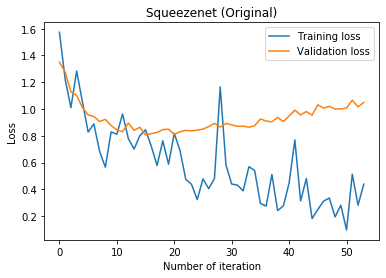

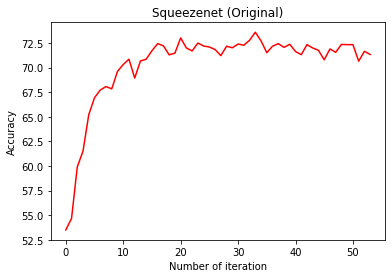

Mean time per epoch 23.20761729661128 seconds
Best accuracy: 73.6  Best training loss: 0.096737802028656  Best validation loss: 0.8069479709863662


In [0]:
  # visualization loss 
plt.plot(iteration_list,loss_list, label='Training loss')
plt.plot(iteration_list,loss_list_test, label='Validation loss')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Squeezenet (Original)")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("Squeezenet (Original)")
plt.show()

print(f"Mean time per epoch {np.mean(execution_time)} seconds") # returns time in sec 
print(f"Best accuracy: {best_acc}  Best training loss: {min(loss_list)}  Best validation loss: {min(loss_list_test)}")


In [0]:
print(str(iteration_list))
print(str(loss_list))
print(str(loss_list_test))
print(str(accuracy_list))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
[1.5736654996871948, 1.2229846715927124, 1.0099021196365356, 1.2836661338806152, 1.0553721189498901, 0.8274673223495483, 0.8884718418121338, 0.6834949254989624, 0.5655368566513062, 0.8289435505867004, 0.8113844394683838, 0.962935209274292, 0.779599666595459, 0.7010205984115601, 0.8003870248794556, 0.8447260856628418, 0.7219758033752441, 0.5783211588859558, 0.7622759342193604, 0.5874494314193726, 0.8189527988433838, 0.6898026466369629, 0.4748799800872803, 0.4375569820404053, 0.32292935252189636, 0.4775329530239105, 0.4046761989593506, 0.48076844215393066, 1.1655406951904297, 0.5826317667961121, 0.43950164318084717, 0.4316883087158203, 0.3884623348712921, 0.5691026449203491, 0.5401845574378967, 0.2944376468658447, 0.2753751277923584, 0.5109671354293823, 0.24080008268356323, 0.27642711

## squeeze skip residuals (batch normed) (2 extra layers depth)

In [0]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo

__all__ = ['SqueezeNet', 'squeezenet1_0', 'squeezenet1_1']

model_urls = {
    'squeezenet1_0': 'https://download.pytorch.org/models/squeezenet1_0-a815701f.pth',
    'squeezenet1_1': 'https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth',
}


class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.bns1 = nn.BatchNorm2d(squeeze_planes)

        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.bne1 = nn.BatchNorm2d(expand1x1_planes)

        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        self.bne3 = nn.BatchNorm2d(expand3x3_planes)

        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.bns1(self.squeeze(x)))


        return torch.cat([
            self.expand1x1_activation(self.bne1(self.expand1x1(x))),
            self.expand3x3_activation(self.bne3(self.expand3x3(x)))
        ], 1)


class SqueezeNet(nn.Module):

    def __init__(self, version='1_0', num_classes=1000):
        super(SqueezeNet, self).__init__()
        self.num_classes = num_classes
        # self.features = nn.Sequential(
        #         nn.Conv2d(3, 96, kernel_size=7, stride=2),
        #         nn.ReLU(inplace=True),
        #         nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        #         Fire(96, 16, 64, 64),
        #         Fire(128, 16, 64, 64),
        #         Fire(128, 32, 128, 128),
        #         nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        #         Fire(256, 32, 128, 128),
        #         Fire(256, 48, 192, 192),
        #         Fire(384, 48, 192, 192),
        #         Fire(384, 64, 256, 256),
        #         nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        #         Fire(512, 64, 256, 256),
        # )
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=7, stride=2),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(96, 16, 64, 64),
        )
        self.block1 = nn.Sequential(
            Fire(128, 16, 64, 64),
        )
        self.features2 = nn.Sequential(
            Fire(128, 32, 128, 128),
            #nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        )
        self.block2 = nn.Sequential(
            Fire(256, 32, 128, 128),
        )
        self.features3 = nn.Sequential(
            Fire(256, 48, 192, 192),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        )
        self.block3 = nn.Sequential(
            Fire(384, 48, 192, 192),
        )
        self.features4 = nn.Sequential(
            Fire(384, 64, 256, 256),
            #nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        
        )
        self.block4 = nn.Sequential(
            Fire(512, 64, 256, 256),
        )
        self.features5 = nn.Sequential(
            Fire(512, 80, 320, 320),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        )
        self.block5 = nn.Sequential(
            Fire(640, 80, 320, 320),
        )

        self.features6 = nn.Sequential(
            Fire(640, 96, 384, 384),
            #nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        )
       
        self.block6 = nn.Sequential(
            Fire(768, 96, 384, 384),
        )
        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(768, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.BatchNorm2d(self.num_classes),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features1(x)

        residual1 = x
        x = self.block1(x)
        x += residual1

        x = self.features2(x)

        residual2 = x
        x = self.block2(x)
        x += residual2

        x = self.features3(x)

        residual3 = x
        x = self.block3(x)
        x += residual3

        x = self.features4(x)

        residual4 = x
        x = self.block4(x)
        x += residual4

        x = self.features5(x)

        residual5 = x
        x = self.block5(x)
        x += residual5

        x = self.features6(x)

        residual6 = x
        x = self.block6(x)
        x += residual6

        x = self.classifier(x)
        return torch.flatten(x, 1)


def _squeezenet(version, pretrained, progress, **kwargs):
    model = SqueezeNet(version, **kwargs)
    if pretrained:
        arch = 'squeezenet' + version
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def squeezenet1_0(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet model architecture from the `"SqueezeNet: AlexNet-level
    accuracy with 50x fewer parameters and <0.5MB model size"
    <https://arxiv.org/abs/1602.07360>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_0', pretrained, progress, **kwargs)


def squeezenet1_1(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet 1.1 model from the `official SqueezeNet repo
    <https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1>`_.
    SqueezeNet 1.1 has 2.4x less computation and slightly fewer parameters
    than SqueezeNet 1.0, without sacrificing accuracy.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_1', pretrained, progress, **kwargs)

In [0]:

#change the line below for different models

# import torchvision.models as models
# model = models.squeezenet1_0(pretrained=True)

model = squeezenet1_0(num_classes=10)

#print(model)

model = model.to(device=device, dtype=torch.float)

# Cross Entropy Loss 
error = CrossEntropyLoss().to(device=device, dtype=torch.float)

#Optimizer
learning_rate = 0.1
optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=learning_rate)

#Optimizer adam
# learning_rate = 0.04
# optimizer = Adam(model.parameters(), lr=learning_rate)
# optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, dampening=0, weight_decay=0.0002, nesterov=False)
# optimizer = SGD(model.parameters(), lr=learning_rate)

#adaptive learning rate
# how many epoc before decreasing learning rate
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [0]:
#load trained dictionary
PATH = '/content/squeezenet_loss.pth'
model.load_state_dict(torch.load(PATH))

In [0]:
%%time
#training/testing
loss_list = []
loss_list_test = []
iteration_list = []
accuracy_list = []
# execution time checking
execution_time = []

PATH = '/content/squeezenet_acc.pth'
best_model_wts = copy.deepcopy(model.state_dict())
PATH2 = '/content/squeezenet_loss.pth'
best_model_loss = copy.deepcopy(model.state_dict())

#PATH = '/content/modified_mnist_effb2_pre_original_latest.pth'
#latest_model_wts = copy.deepcopy(model.state_dict())
best_loss = float("inf")
best_acc = 0.0
#set number of epochs 
num_epochs = 100
for epoch in range(num_epochs):
    #print("\nTrain Epoch {}: lr = {}".format(epoch, exp_lr_scheduler.get_lr()[0]))
    print("\nTrain Epoch {}: lr = {}".format(epoch,learning_rate))

    start = timeit.default_timer()
    loss_list.append(train(epoch, train_loader, model, error, optimizer, batch_size))
    loss_test, accuracy = test(test_loader, model, error, batch_size)
    stop = timeit.default_timer()
    etime = stop - start
    execution_time.append(etime)

    loss_list_test.append(loss_test)
    accuracy_list.append(accuracy)
    iteration_list.append(epoch)
    #exp_lr_scheduler.step()

    #saving model with best acc 
    if accuracy > best_acc:
      print(f"Better accuracy at Epoch {epoch}: accuracy = {accuracy}%")
      best_acc = accuracy
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(best_model_wts, PATH)
    #saving model with best loss
    if loss_test < best_loss:
      print(f"Better loss at Epoch {epoch}: loss = {loss_test}%")
      best_loss = loss_test
      best_model_loss = copy.deepcopy(model.state_dict())
      torch.save(best_model_loss, PATH2)
#load model
# model = Net()
# model.load_state_dict(torch.load(PATH))


Train Epoch 0: lr = 0.1
Train Epoch: 0 [5000/50000 (10%)]	Train Loss: 2.233442
Train Epoch: 0 [10000/50000 (20%)]	Train Loss: 1.980543
Train Epoch: 0 [15000/50000 (30%)]	Train Loss: 1.880717
Train Epoch: 0 [20000/50000 (40%)]	Train Loss: 1.795509
Train Epoch: 0 [25000/50000 (50%)]	Train Loss: 1.720093
Train Epoch: 0 [30000/50000 (60%)]	Train Loss: 1.698942
Train Epoch: 0 [35000/50000 (70%)]	Train Loss: 1.651946
Train Epoch: 0 [40000/50000 (80%)]	Train Loss: 1.593989
Train Epoch: 0 [45000/50000 (90%)]	Train Loss: 1.589501

Test set: Test loss: 1.5121, Accuracy: 2353/5000 (47%)

Better accuracy at Epoch 0: accuracy = 47.06%
Better loss at Epoch 0: loss = 1.5121425127983095%

Train Epoch 1: lr = 0.1
Train Epoch: 1 [5000/50000 (10%)]	Train Loss: 1.526160
Train Epoch: 1 [10000/50000 (20%)]	Train Loss: 1.440299
Train Epoch: 1 [15000/50000 (30%)]	Train Loss: 1.467156
Train Epoch: 1 [20000/50000 (40%)]	Train Loss: 1.424484
Train Epoch: 1 [25000/50000 (50%)]	Train Loss: 1.410444
Train Epoch: 1

KeyboardInterrupt: ignored

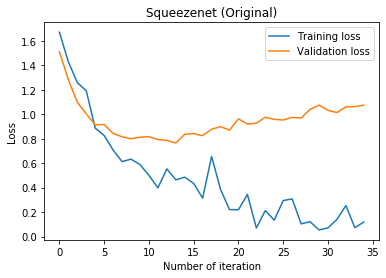

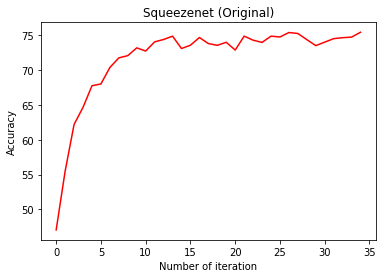

Mean time per epoch 48.546672692571406 seconds
Best accuracy: 75.44  Best training loss: 0.05418708920478821  Best validation loss: 0.7652966991066933


In [0]:
  # visualization loss 
plt.plot(iteration_list,loss_list, label='Training loss')
plt.plot(iteration_list,loss_list_test, label='Validation loss')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Squeezenet (Original)")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("Squeezenet (Original)")
plt.show()

print(f"Mean time per epoch {np.mean(execution_time)} seconds") # returns time in sec 
print(f"Best accuracy: {best_acc}  Best training loss: {min(loss_list)}  Best validation loss: {min(loss_list_test)}")


In [0]:
print(str(iteration_list))
print(str(loss_list))
print(str(loss_list_test))
print(str(accuracy_list))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
[1.671850562095642, 1.4294451475143433, 1.2597286701202393, 1.1926536560058594, 0.8873090147972107, 0.826803982257843, 0.7074623107910156, 0.6133054494857788, 0.633284330368042, 0.5885295867919922, 0.5012684464454651, 0.39865317940711975, 0.5535438656806946, 0.4638020396232605, 0.485892653465271, 0.43394768238067627, 0.3143607974052429, 0.6553335785865784, 0.38519614934921265, 0.22057229280471802, 0.21904069185256958, 0.3447380065917969, 0.07020840048789978, 0.21228760480880737, 0.13398712873458862, 0.2944369614124298, 0.3080297112464905, 0.1039414182305336, 0.12129847705364227, 0.05418708920478821, 0.07100073993206024, 0.14000892639160156, 0.2532752454280853, 0.07283256202936172, 0.11819754540920258]
[1.5121425127983095, 1.2824513864517206, 1.0977454257011414, 1.003833923339844, 0.9143832659721375, 0.916989808678627, 0.8439497417211532, 0.8161922967433932,

## squeeze skip residuals (batch normed) (2 extra layers for residuals)

In [0]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo

__all__ = ['SqueezeNet', 'squeezenet1_0', 'squeezenet1_1']

model_urls = {
    'squeezenet1_0': 'https://download.pytorch.org/models/squeezenet1_0-a815701f.pth',
    'squeezenet1_1': 'https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth',
}


class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.bns1 = nn.BatchNorm2d(squeeze_planes)

        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.bne1 = nn.BatchNorm2d(expand1x1_planes)

        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        self.bne3 = nn.BatchNorm2d(expand3x3_planes)

        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.bns1(self.squeeze(x)))


        return torch.cat([
            self.expand1x1_activation(self.bne1(self.expand1x1(x))),
            self.expand3x3_activation(self.bne3(self.expand3x3(x)))
        ], 1)


class SqueezeNet(nn.Module):

    def __init__(self, version='1_0', num_classes=1000):
        super(SqueezeNet, self).__init__()
        self.num_classes = num_classes
        # self.features = nn.Sequential(
        #         nn.Conv2d(3, 96, kernel_size=7, stride=2),
        #         nn.ReLU(inplace=True),
        #         nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        #         Fire(96, 16, 64, 64),
        #         Fire(128, 16, 64, 64),
        #         Fire(128, 32, 128, 128),
        #         nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        #         Fire(256, 32, 128, 128),
        #         Fire(256, 48, 192, 192),
        #         Fire(384, 48, 192, 192),
        #         Fire(384, 64, 256, 256),
        #         nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        #         Fire(512, 64, 256, 256),
        # )
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=7, stride=2),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(96, 16, 64, 64),
        )
        self.block1 = nn.Sequential(
            Fire(128, 16, 64, 64),
        )
        self.block11 = nn.Sequential(
            Fire(128, 16, 64, 64),
        )
        self.features2 = nn.Sequential(
            Fire(128, 32, 128, 128),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        )
        self.block2 = nn.Sequential(
            Fire(256, 32, 128, 128),
        )
        self.block22 = nn.Sequential(
            Fire(256, 32, 128, 128),
        )
        self.features3 = nn.Sequential(
            Fire(256, 48, 192, 192),
        )
        self.block3 = nn.Sequential(
            Fire(384, 48, 192, 192),
        )
        # self.block33 = nn.Sequential(
        #     Fire(384, 48, 192, 192),
        # )
        self.features4 = nn.Sequential(
            Fire(384, 64, 256, 256),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        
        )
        self.block4 = nn.Sequential(
            Fire(512, 64, 256, 256),
        )
        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.BatchNorm2d(self.num_classes),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features1(x)

        residual1 = x
        x = self.block1(x)
        x += residual1
        residual11 = x
        x = self.block11(x)
        x += residual11

        x = self.features2(x)

        residual2 = x
        x = self.block2(x)
        x += residual2
        residual22 = x
        x = self.block22(x)
        x += residual22

        x = self.features3(x)

        residual3 = x
        x = self.block3(x)
        x += residual3
        # residual33 = x
        # x = self.block33(x)
        # x += residual33

        x = self.features4(x)

        residual4 = x
        x = self.block4(x)
        x += residual4

        x = self.classifier(x)
        return torch.flatten(x, 1)


def _squeezenet(version, pretrained, progress, **kwargs):
    model = SqueezeNet(version, **kwargs)
    if pretrained:
        arch = 'squeezenet' + version
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def squeezenet1_0(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet model architecture from the `"SqueezeNet: AlexNet-level
    accuracy with 50x fewer parameters and <0.5MB model size"
    <https://arxiv.org/abs/1602.07360>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_0', pretrained, progress, **kwargs)


def squeezenet1_1(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet 1.1 model from the `official SqueezeNet repo
    <https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1>`_.
    SqueezeNet 1.1 has 2.4x less computation and slightly fewer parameters
    than SqueezeNet 1.0, without sacrificing accuracy.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_1', pretrained, progress, **kwargs)

In [0]:

#change the line below for different models

# import torchvision.models as models
# model = models.squeezenet1_0(pretrained=True)

model = squeezenet1_0(num_classes=10)

#print(model)

model = model.to(device=device, dtype=torch.float)

# Cross Entropy Loss 
error = CrossEntropyLoss().to(device=device, dtype=torch.float)

#Optimizer
learning_rate = 0.1
optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=learning_rate)

#Optimizer adam
# learning_rate = 0.04
# optimizer = Adam(model.parameters(), lr=learning_rate)
# optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, dampening=0, weight_decay=0.0002, nesterov=False)
# optimizer = SGD(model.parameters(), lr=learning_rate)

#adaptive learning rate
# how many epoc before decreasing learning rate
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [0]:
#load trained dictionary
PATH = '/content/squeezenet_loss.pth'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [0]:
%%time
#training/testing
loss_list = []
loss_list_test = []
iteration_list = []
accuracy_list = []
# execution time checking
execution_time = []

PATH = '/content/squeezenet_acc.pth'
best_model_wts = copy.deepcopy(model.state_dict())
PATH2 = '/content/squeezenet_loss.pth'
best_model_loss = copy.deepcopy(model.state_dict())

#PATH = '/content/modified_mnist_effb2_pre_original_latest.pth'
#latest_model_wts = copy.deepcopy(model.state_dict())
best_loss = float("inf")
best_acc = 0.0
#set number of epochs 
num_epochs = 100
for epoch in range(num_epochs):
    #print("\nTrain Epoch {}: lr = {}".format(epoch, exp_lr_scheduler.get_lr()[0]))
    print("\nTrain Epoch {}: lr = {}".format(epoch,learning_rate))

    start = timeit.default_timer()
    loss_list.append(train(epoch, train_loader, model, error, optimizer, batch_size))
    loss_test, accuracy = test(test_loader, model, error, batch_size)
    stop = timeit.default_timer()
    etime = stop - start
    execution_time.append(etime)

    loss_list_test.append(loss_test)
    accuracy_list.append(accuracy)
    iteration_list.append(epoch)
    #exp_lr_scheduler.step()

    #saving model with best acc 
    if accuracy > best_acc:
      print(f"Better accuracy at Epoch {epoch}: accuracy = {accuracy}%")
      best_acc = accuracy
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(best_model_wts, PATH)
    #saving model with best loss
    if loss_test < best_loss:
      print(f"Better loss at Epoch {epoch}: loss = {loss_test}%")
      best_loss = loss_test
      best_model_loss = copy.deepcopy(model.state_dict())
      torch.save(best_model_loss, PATH2)
#load model
# model = Net()
# model.load_state_dict(torch.load(PATH))


Train Epoch 0: lr = 0.1
Train Epoch: 0 [5000/50000 (10%)]	Train Loss: 2.189392
Train Epoch: 0 [10000/50000 (20%)]	Train Loss: 1.918506
Train Epoch: 0 [15000/50000 (30%)]	Train Loss: 1.831333
Train Epoch: 0 [20000/50000 (40%)]	Train Loss: 1.753702
Train Epoch: 0 [25000/50000 (50%)]	Train Loss: 1.701960
Train Epoch: 0 [30000/50000 (60%)]	Train Loss: 1.639620
Train Epoch: 0 [35000/50000 (70%)]	Train Loss: 1.572478
Train Epoch: 0 [40000/50000 (80%)]	Train Loss: 1.546740
Train Epoch: 0 [45000/50000 (90%)]	Train Loss: 1.503192

Test set: Test loss: 1.4009, Accuracy: 2560/5000 (51%)

Better accuracy at Epoch 0: accuracy = 51.2%
Better loss at Epoch 0: loss = 1.400896774530411%

Train Epoch 1: lr = 0.1
Train Epoch: 1 [5000/50000 (10%)]	Train Loss: 1.405455
Train Epoch: 1 [10000/50000 (20%)]	Train Loss: 1.387146
Train Epoch: 1 [15000/50000 (30%)]	Train Loss: 1.407003
Train Epoch: 1 [20000/50000 (40%)]	Train Loss: 1.336567
Train Epoch: 1 [25000/50000 (50%)]	Train Loss: 1.336836
Train Epoch: 1 [

KeyboardInterrupt: ignored

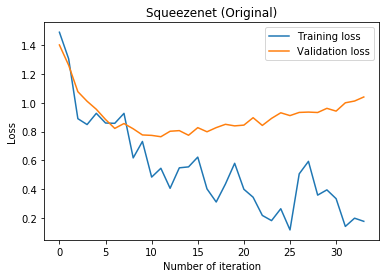

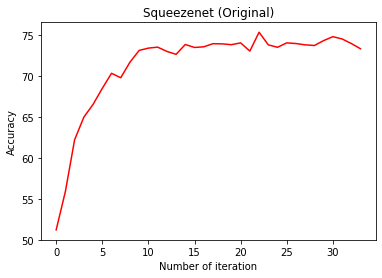

Mean time per epoch 40.30431194623527 seconds
Best accuracy: 75.36  Best training loss: 0.11685790121555328  Best validation loss: 0.7638533076643943


In [0]:
  # visualization loss 
plt.plot(iteration_list,loss_list, label='Training loss')
plt.plot(iteration_list,loss_list_test, label='Validation loss')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Squeezenet (Original)")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("Squeezenet (Original)")
plt.show()

print(f"Mean time per epoch {np.mean(execution_time)} seconds") # returns time in sec 
print(f"Best accuracy: {best_acc}  Best training loss: {min(loss_list)}  Best validation loss: {min(loss_list_test)}")


In [0]:
print(str(iteration_list))
print(str(loss_list))
print(str(loss_list_test))
print(str(accuracy_list))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
[1.4892572164535522, 1.304968237876892, 0.889128565788269, 0.8483538031578064, 0.9262908101081848, 0.8590133190155029, 0.8569309115409851, 0.9260328412055969, 0.6168851852416992, 0.7309474349021912, 0.48363128304481506, 0.5448474884033203, 0.4057130813598633, 0.5479651689529419, 0.5544900298118591, 0.6224130392074585, 0.40180450677871704, 0.3106207847595215, 0.4355888068675995, 0.5793075561523438, 0.3990998864173889, 0.3439003825187683, 0.2174069583415985, 0.1814344972372055, 0.26400136947631836, 0.11685790121555328, 0.5061777234077454, 0.5928786993026733, 0.35849058628082275, 0.394870400428772, 0.33372604846954346, 0.14104095101356506, 0.19826139509677887, 0.1764681190252304]
[1.400896774530411, 1.2604336732625963, 1.0765493458509445, 1.0101558506488797, 0.9544164842367173, 0.8835893097519871, 0.8215996313095091, 0.8554058110713961, 0.8189084324240686, 0.77619

## squeeze skip residuals (batch normed) (4 extra layers for residuals)

In [0]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo

__all__ = ['SqueezeNet', 'squeezenet1_0', 'squeezenet1_1']

model_urls = {
    'squeezenet1_0': 'https://download.pytorch.org/models/squeezenet1_0-a815701f.pth',
    'squeezenet1_1': 'https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth',
}


class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.bns1 = nn.BatchNorm2d(squeeze_planes)

        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.bne1 = nn.BatchNorm2d(expand1x1_planes)

        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        self.bne3 = nn.BatchNorm2d(expand3x3_planes)

        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.bns1(self.squeeze(x)))


        return torch.cat([
            self.expand1x1_activation(self.bne1(self.expand1x1(x))),
            self.expand3x3_activation(self.bne3(self.expand3x3(x)))
        ], 1)


class SqueezeNet(nn.Module):

    def __init__(self, version='1_0', num_classes=1000):
        super(SqueezeNet, self).__init__()
        self.num_classes = num_classes
        # self.features = nn.Sequential(
        #         nn.Conv2d(3, 96, kernel_size=7, stride=2),
        #         nn.ReLU(inplace=True),
        #         nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        #         Fire(96, 16, 64, 64),
        #         Fire(128, 16, 64, 64),
        #         Fire(128, 32, 128, 128),
        #         nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        #         Fire(256, 32, 128, 128),
        #         Fire(256, 48, 192, 192),
        #         Fire(384, 48, 192, 192),
        #         Fire(384, 64, 256, 256),
        #         nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        #         Fire(512, 64, 256, 256),
        # )
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=7, stride=2),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(96, 16, 64, 64),
        )
        self.block1 = nn.Sequential(
            Fire(128, 16, 64, 64),
        )
        self.block11 = nn.Sequential(
            Fire(128, 16, 64, 64),
        )
        self.features2 = nn.Sequential(
            Fire(128, 32, 128, 128),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        )
        self.block2 = nn.Sequential(
            Fire(256, 32, 128, 128),
        )
        self.block22 = nn.Sequential(
            Fire(256, 32, 128, 128),
        )
        self.features3 = nn.Sequential(
            Fire(256, 48, 192, 192),
        )
        self.block3 = nn.Sequential(
            Fire(384, 48, 192, 192),
        )
        self.block33 = nn.Sequential(
            Fire(384, 48, 192, 192),
        )
        self.features4 = nn.Sequential(
            Fire(384, 64, 256, 256),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        
        )
        self.block4 = nn.Sequential(
            Fire(512, 64, 256, 256),
        )
        self.block44 = nn.Sequential(
            Fire(512, 64, 256, 256),
        )
        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.BatchNorm2d(self.num_classes),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features1(x)

        residual1 = x
        x = self.block1(x)
        x += residual1
        residual11 = x
        x = self.block11(x)
        x += residual11

        x = self.features2(x)

        residual2 = x
        x = self.block2(x)
        x += residual2
        residual22 = x
        x = self.block22(x)
        x += residual22

        x = self.features3(x)

        residual3 = x
        x = self.block3(x)
        x += residual3
        residual33 = x
        x = self.block33(x)
        x += residual33

        x = self.features4(x)

        residual4 = x
        x = self.block4(x)
        x += residual4
        residual44 = x
        x = self.block44(x)
        x += residual44
        
        x = self.classifier(x)
        return torch.flatten(x, 1)


def _squeezenet(version, pretrained, progress, **kwargs):
    model = SqueezeNet(version, **kwargs)
    if pretrained:
        arch = 'squeezenet' + version
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def squeezenet1_0(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet model architecture from the `"SqueezeNet: AlexNet-level
    accuracy with 50x fewer parameters and <0.5MB model size"
    <https://arxiv.org/abs/1602.07360>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_0', pretrained, progress, **kwargs)


def squeezenet1_1(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet 1.1 model from the `official SqueezeNet repo
    <https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1>`_.
    SqueezeNet 1.1 has 2.4x less computation and slightly fewer parameters
    than SqueezeNet 1.0, without sacrificing accuracy.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_1', pretrained, progress, **kwargs)

In [0]:

#change the line below for different models

# import torchvision.models as models
# model = models.squeezenet1_0(pretrained=True)

model = squeezenet1_0(num_classes=10)

#print(model)

model = model.to(device=device, dtype=torch.float)

# Cross Entropy Loss 
error = CrossEntropyLoss().to(device=device, dtype=torch.float)

#Optimizer
learning_rate = 0.1
optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=learning_rate)

#Optimizer adam
# learning_rate = 0.04
# optimizer = Adam(model.parameters(), lr=learning_rate)
# optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, dampening=0, weight_decay=0.0002, nesterov=False)
# optimizer = SGD(model.parameters(), lr=learning_rate)

#adaptive learning rate
# how many epoc before decreasing learning rate
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [0]:
#load trained dictionary
PATH = '/content/squeezenet_loss.pth'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [0]:
%%time
#training/testing
loss_list = []
loss_list_test = []
iteration_list = []
accuracy_list = []
# execution time checking
execution_time = []

PATH = '/content/squeezenet_acc.pth'
best_model_wts = copy.deepcopy(model.state_dict())
PATH2 = '/content/squeezenet_loss.pth'
best_model_loss = copy.deepcopy(model.state_dict())

#PATH = '/content/modified_mnist_effb2_pre_original_latest.pth'
#latest_model_wts = copy.deepcopy(model.state_dict())
best_loss = float("inf")
best_acc = 0.0
#set number of epochs 
num_epochs = 100
for epoch in range(num_epochs):
    #print("\nTrain Epoch {}: lr = {}".format(epoch, exp_lr_scheduler.get_lr()[0]))
    print("\nTrain Epoch {}: lr = {}".format(epoch,learning_rate))

    start = timeit.default_timer()
    loss_list.append(train(epoch, train_loader, model, error, optimizer, batch_size))
    loss_test, accuracy = test(test_loader, model, error, batch_size)
    stop = timeit.default_timer()
    etime = stop - start
    execution_time.append(etime)

    loss_list_test.append(loss_test)
    accuracy_list.append(accuracy)
    iteration_list.append(epoch)
    #exp_lr_scheduler.step()

    #saving model with best acc 
    if accuracy > best_acc:
      print(f"Better accuracy at Epoch {epoch}: accuracy = {accuracy}%")
      best_acc = accuracy
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(best_model_wts, PATH)
    #saving model with best loss
    if loss_test < best_loss:
      print(f"Better loss at Epoch {epoch}: loss = {loss_test}%")
      best_loss = loss_test
      best_model_loss = copy.deepcopy(model.state_dict())
      torch.save(best_model_loss, PATH2)
#load model
# model = Net()
# model.load_state_dict(torch.load(PATH))


Train Epoch 0: lr = 0.1
Train Epoch: 0 [5000/50000 (10%)]	Train Loss: 2.278577
Train Epoch: 0 [10000/50000 (20%)]	Train Loss: 2.001624
Train Epoch: 0 [15000/50000 (30%)]	Train Loss: 1.868917
Train Epoch: 0 [20000/50000 (40%)]	Train Loss: 1.755066
Train Epoch: 0 [25000/50000 (50%)]	Train Loss: 1.739366
Train Epoch: 0 [30000/50000 (60%)]	Train Loss: 1.672918
Train Epoch: 0 [35000/50000 (70%)]	Train Loss: 1.630520
Train Epoch: 0 [40000/50000 (80%)]	Train Loss: 1.571283
Train Epoch: 0 [45000/50000 (90%)]	Train Loss: 1.541608

Test set: Test loss: 1.4487, Accuracy: 2477/5000 (50%)

Better accuracy at Epoch 0: accuracy = 49.54%
Better loss at Epoch 0: loss = 1.4487174665927887%

Train Epoch 1: lr = 0.1
Train Epoch: 1 [5000/50000 (10%)]	Train Loss: 1.445172
Train Epoch: 1 [10000/50000 (20%)]	Train Loss: 1.418047
Train Epoch: 1 [15000/50000 (30%)]	Train Loss: 1.432177
Train Epoch: 1 [20000/50000 (40%)]	Train Loss: 1.348816
Train Epoch: 1 [25000/50000 (50%)]	Train Loss: 1.363841
Train Epoch: 1

KeyboardInterrupt: ignored

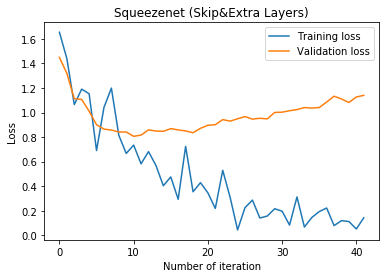

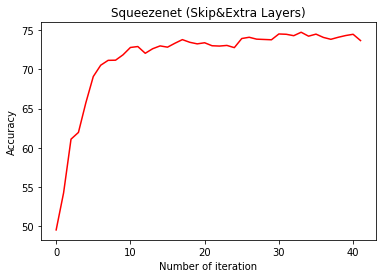

Mean time per epoch 45.474914494809504 seconds
Best accuracy: 74.72  Best training loss: 0.04415479674935341  Best validation loss: 0.8063691279292109


In [0]:
  # visualization loss 
plt.plot(iteration_list,loss_list, label='Training loss')
plt.plot(iteration_list,loss_list_test, label='Validation loss')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Squeezenet (Skip&Extra Layers)")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("Squeezenet (Skip&Extra Layers)")
plt.show()

print(f"Mean time per epoch {np.mean(execution_time)} seconds") # returns time in sec 
print(f"Best accuracy: {best_acc}  Best training loss: {min(loss_list)}  Best validation loss: {min(loss_list_test)}")


In [0]:
print(str(iteration_list))
print(str(loss_list))
print(str(loss_list_test))
print(str(accuracy_list))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
[1.6536296606063843, 1.4398102760314941, 1.064573049545288, 1.1902273893356323, 1.1529728174209595, 0.6907373070716858, 1.04155695438385, 1.1986956596374512, 0.8147517442703247, 0.6668054461479187, 0.7346854209899902, 0.5823341608047485, 0.6819490194320679, 0.5692170858383179, 0.4035908877849579, 0.47556304931640625, 0.29393941164016724, 0.7242833971977234, 0.3548170328140259, 0.4286886155605316, 0.34619057178497314, 0.21889831125736237, 0.5294685959815979, 0.3082839548587799, 0.04415479674935341, 0.22535362839698792, 0.2871718108654022, 0.14088304340839386, 0.15735384821891785, 0.2165956050157547, 0.19633236527442932, 0.08345698565244675, 0.3127736747264862, 0.06781768053770065, 0.145253986120224, 0.19343358278274536, 0.2224409282207489, 0.07933913916349411, 0.11991449445486069, 0.11226620525121689, 0.05171310529112816, 0.143263